Title & Description: 
Building A lightweight U-Net for brain tumor segmentation (using BraTS dataset) under limited GPU resources, and comparing performance (Dice score + qualitative results) to the BraTS 2020 nnU-Net winner (DKFZ_MIC).

Imports & Setup

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Processing Libs 
import skimage as ski
import PIL.Image as Image

# NN libs
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Neural Imaging Libs
import nibabel as nib
import nilearn.plotting as nlplt
import nilearn as nl

#Getting helper scripts
from utils.data_loader import BraTSDatasetP1, BraTSDatasetP3, BraTSDatasetP2, get_brats_filepaths, build_cache, visualize_patient_consistency, split_brats_dataset
from utils.metrics import compare_pipelines_dice, DiceCELoss
from utils.unet import UNet3D, UNet3D_optimized

from utils.train_unet import run_experiment
from utils.evaluate_unet import eval_experiment, visualize_prediction
from utils.seeding import set_global_seed


In [2]:
# General Paths
RAW_DATA_PATH = "data/raw/"
PROCESSED_DATA_PATH = "data/processed/"
MODELS_PATH = "models/"
RESULTS_PATH = "results/"


Loading and Visualizing sample data

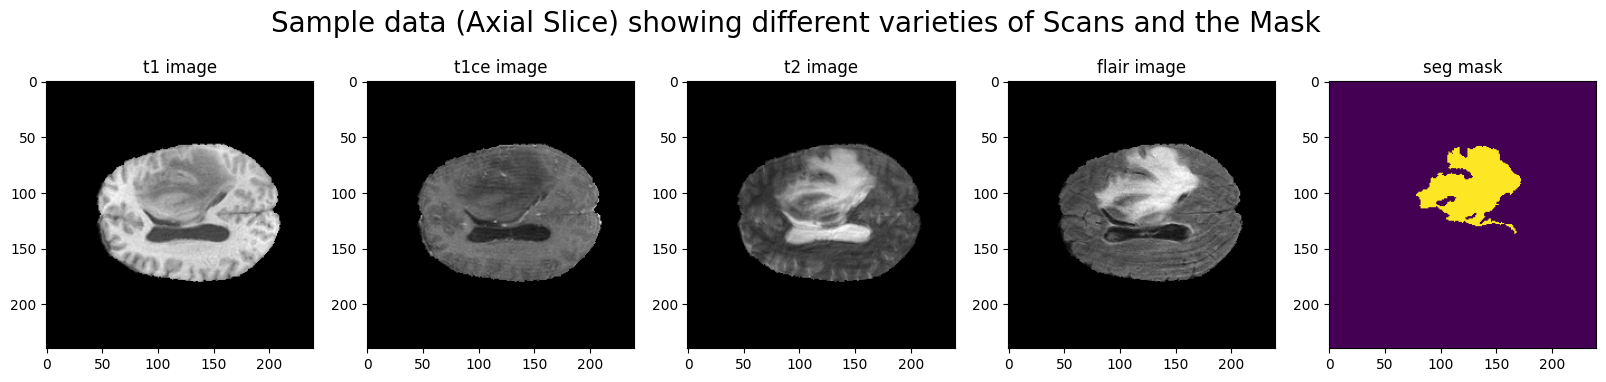

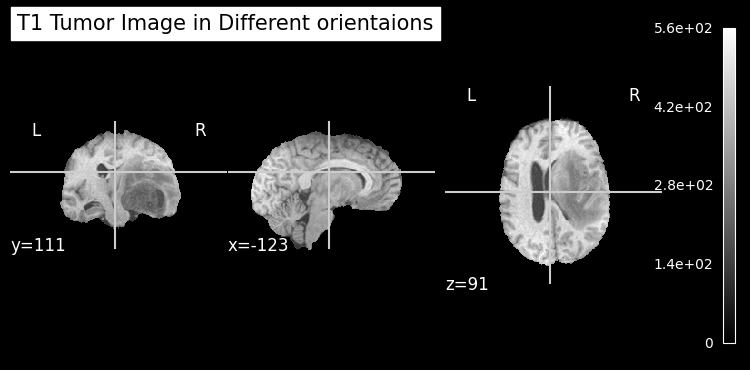

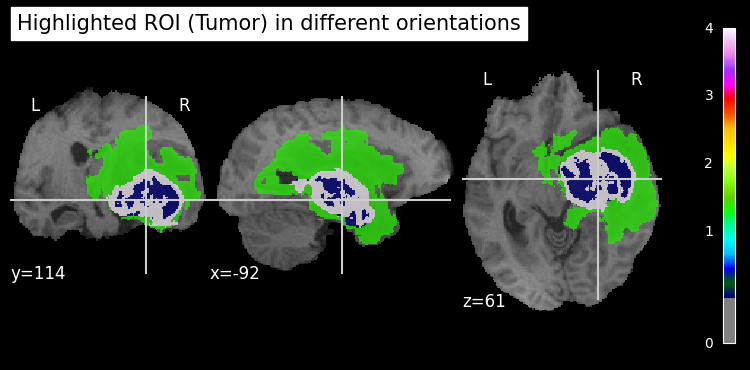

In [4]:
###
Test_filepath = "data/raw/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/"
# Loading data and extracting image data with "get_fdata()"
test_t1_image = nib.load(Test_filepath + "BraTS20_Training_001_t1.nii").get_fdata()
test_t1ce_image = nib.load(Test_filepath + "BraTS20_Training_001_t1ce.nii").get_fdata()
test_t2_image = nib.load(Test_filepath + "BraTS20_Training_001_t2.nii").get_fdata()
test_flair_image = nib.load(Test_filepath + "BraTS20_Training_001_flair.nii").get_fdata()
test_mask = nib.load(Test_filepath + "BraTS20_Training_001_seg.nii").get_fdata()

volume_show = 89 #Orientation to view 

# Visualizing sample of Image data
 
fig , (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (20, 10))

fig.suptitle('Sample data (Axial Slice) showing different varieties of Scans and the Mask'
            , y=0.70, fontsize=20 )

ax1.imshow(test_t1_image[:,:,volume_show], cmap = "gray")
ax1.set_title("t1 image")

ax2.imshow(test_t1ce_image[:,:,volume_show], cmap = "gray")
ax2.set_title("t1ce image")

ax3.imshow(test_t2_image[:,:,volume_show], cmap = "gray")
ax3.set_title("t2 image")

ax4.imshow(test_flair_image[:,:,volume_show], cmap = "gray")
ax4.set_title("flair image")

ax5.imshow(test_mask[:,:,volume_show])
ax5.set_title("seg mask")

nl_test_t1_image = nl.image.load_img(Test_filepath + "BraTS20_Training_001_t1.nii")
nl_test_mask_image = nl.image.load_img(Test_filepath + "BraTS20_Training_001_seg.nii")

nlplt.plot_epi(nl_test_t1_image, title="T1 Tumor Image in Different orientaions")
nlplt.plot_roi(nl_test_mask_image,bg_img=nl_test_t1_image , title="Highlighted ROI (Tumor) in different orientations")

Dataset Preprocessing

In [8]:
#Extract image and mask paths
trainingData_root_dir = os.path.join(RAW_DATA_PATH, "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData") #create directory to data
image_paths, mask_paths = get_brats_filepaths(trainingData_root_dir) ##Collecting image and mask file paths for our data loader 
print(mask_paths[354]) #Test Print

data/raw/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_seg.nii


In [10]:
#  Performing Patientwise split 
train_imgs, val_imgs, train_masks, val_masks = split_brats_dataset(
    image_paths, mask_paths, val_size=0.2, seed=42
)

print(f"Train patients: {len(train_imgs)}")
print(f"Val patients: {len(val_imgs)}")

# Derive patient IDs from the split lists
def pid_from_modalities(modality_paths):
    """
    modality_paths: list of 4 paths [flair, t1, t1ce, t2]
    Returns the patient folder name used in cache (e.g., 'BraTS20_Training_001').
    """
    return os.path.basename(os.path.dirname(modality_paths[0]))

train_pids = [pid_from_modalities(m) for m in train_imgs] #Extracting train patient IDs
val_pids   = [pid_from_modalities(m) for m in val_imgs] #Extracting val patient IDs

# Checking if lengths match
len(train_pids) == len(train_imgs), len(val_pids)  == len(val_imgs)

Train patients: 295
Val patients: 74


(True, True)

DATA preprocessing --> ABLATION STUDIES

We evaluated three different preprocessing pipelines to investigate whether certain preprocessing shortcuts could speed up training without compromising data integrity. The goal was to test if cached volumes or pre-extracted patches (P2, P3) remain comparable to the standard on-the-fly preprocessing approach (P1) in terms of preserving anatomical structures and segmentation quality. These pipelines are built in data_loader.py file

In [13]:
'''
Preparing directories to create Cache (saved image patches and volumes) for P2 and P3 using the split

'''
# Cache directories
cache_root = "data/processed/cache"
cache_train = os.path.join(cache_root, "train")
cache_val   = os.path.join(cache_root, "val")

In [15]:
# # 
'''
Build cache for train and val separately (we execute once and comment out to prevent corrupting the data)

'''
# build_cache(train_imgs, train_masks, out_dir=cache_train, num_patches=8)  # P2 & P3 train
# build_cache(val_imgs, val_masks, out_dir=cache_val, num_patches=8)        # P2 & P3 val

'\nBuild cache for train and val separately (we execute once and comment out to prevent corrupting the data)\n\n'

In [17]:
'''
Creating datasets for each pipeline; P1, P2, P3

'''

# P1 (on the fly)
train_dataset_P1 = BraTSDatasetP1(train_imgs, train_masks, augment=True)
val_dataset_P1   = BraTSDatasetP1(val_imgs,   val_masks,   augment=False)

# P2 (cached volumes)
train_dataset_P2 = BraTSDatasetP2(
    cache_dir=os.path.join(cache_train, "volumes"),
    patient_ids=train_pids,
    patch_size=(96,96,96),
    augment=True
)
val_dataset_P2 = BraTSDatasetP2(
    cache_dir=os.path.join(cache_val, "volumes"),
    patient_ids=val_pids,
    patch_size=(96,96,96),
    augment=False
)

# P3 (cached patches)
train_dataset_P3 = BraTSDatasetP3(
    cache_dir=os.path.join(cache_train, "patches"),
    patient_ids=train_pids,
    augment=True
)
val_dataset_P3 = BraTSDatasetP3(
    cache_dir=os.path.join(cache_val, "patches"),
    patient_ids=val_pids,
    augment=False
)

Plot saved to results/images/patient-9_rand_consistency.png


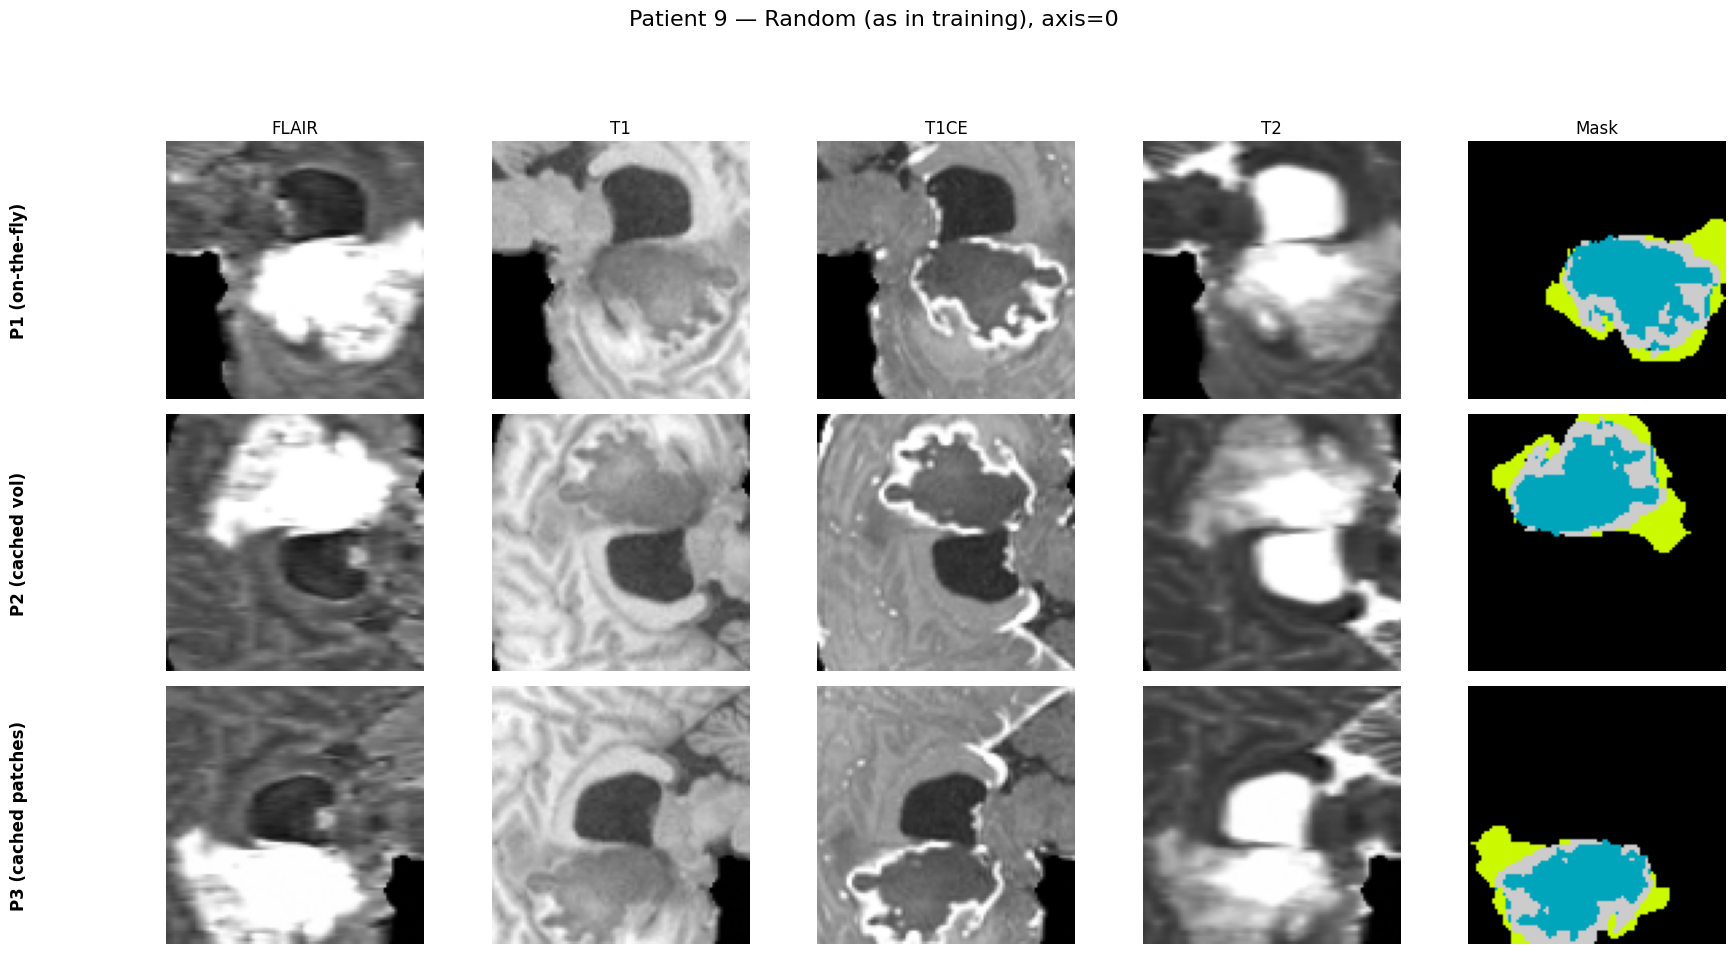

Plot saved to results/images/patient-9_det_consistency.png


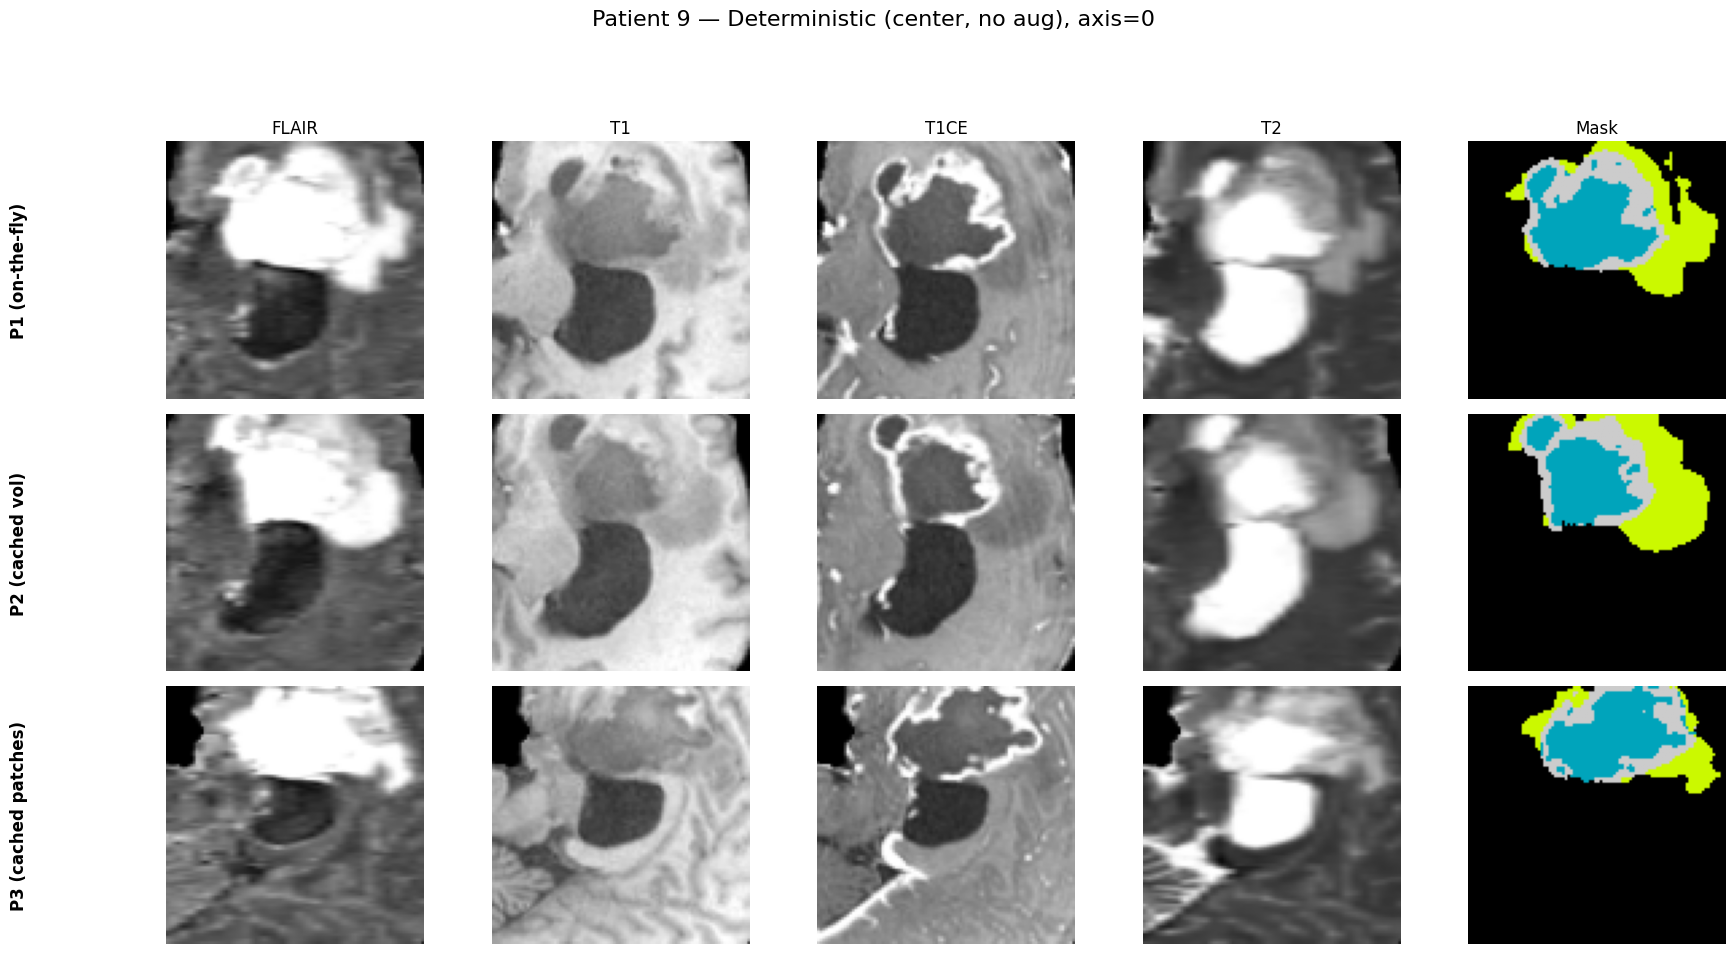

In [37]:
'''
Qualitative Sanity checks: 
Visualizing patches produced by the 3 pipelines -> mainly Checking for consistency of anatomical regions ("what the model sees!")
'''
#What the model really sees after all pipelines have been executed successfully (random patches)
visualize_patient_consistency(train_dataset_P1, train_dataset_P2, train_dataset_P3, patient_idx=9, slice_axis=0, deterministic=False)

#Force centered patches with reversed Augmentations just for sanity check of anatomical regions (Deterministic patches) 
visualize_patient_consistency(train_dataset_P1, train_dataset_P2, train_dataset_P3, patient_idx=9, slice_axis=0, deterministic=True)

In [19]:
# dice scores 
'''
Quantitative Sanity checks: 
Evaluating consistency of tumor regions ("what the model sees!") across preprocessing pipelines, by computing 
Dice similarity coefficients between segmentation masks from the cached pipelines (P2, P3) and the on-the-fly reference (P1). 
Results are summarized as mean ± standard deviation across sampled patches

'''

results = compare_pipelines_dice(train_dataset_P1, train_dataset_P2, train_dataset_P3, num_samples=20)

regions = ["Whole Tumor", "Tumor Core", "Enhancing Tumor", "All Classes"]

# Print P2 vs P1
print("Dice Scores (P2 vs P1):")
for i, region in enumerate(regions):
    mean = results["P2_vs_P1"][0][i]
    std = results["P2_vs_P1"][1][i]
    print(f"  {region:<15}: {mean:.3f} ± {std:.3f}")

# Print P3 vs P1
print("\nDice Scores (P3 vs P1):")
for i, region in enumerate(regions):
    mean = results["P3_vs_P1"][0][i]
    std = results["P3_vs_P1"][1][i]
    print(f"  {region:<15}: {mean:.3f} ± {std:.3f}")

Dice Scores (P2 vs P1):
  Whole Tumor    : 0.827 ± 0.053
  Tumor Core     : 0.224 ± 0.215
  Enhancing Tumor: 0.266 ± 0.138
  All Classes    : 0.333 ± 0.319

Dice Scores (P3 vs P1):
  Whole Tumor    : 0.787 ± 0.060
  Tumor Core     : 0.135 ± 0.171
  Enhancing Tumor: 0.206 ± 0.156
  All Classes    : 0.261 ± 0.341


In [20]:
batch_size = 1
# num_workers = 4
'''
Preparing data for both training and validation (for all three pipelines : P1, P2, P3)

'''


#  DataLoaders
# DataLoaders
train_loader_P1 = DataLoader(
    train_dataset_P1, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=True
)
val_loader_P1 = DataLoader(
    val_dataset_P1, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=True
)

train_loader_P2 = DataLoader(
    train_dataset_P2, batch_size=batch_size, shuffle=True,
    num_workers=1, pin_memory=True
)
val_loader_P2 = DataLoader(
    val_dataset_P2, batch_size=batch_size, shuffle=False,
    num_workers=1, pin_memory=True
)

train_loader_P3 = DataLoader(
    train_dataset_P3, batch_size=batch_size, shuffle=True,
    num_workers=1, pin_memory=True
)
val_loader_P3 = DataLoader(
    val_dataset_P3, batch_size=batch_size, shuffle=False,
    num_workers=1, pin_memory=True
)


def train_loader_printout(train_loader):
    for img, mask in train_loader:
        print("Image shape:", img.shape)   # (B,4,96,96,96)  four MRI modalities
        print("Mask shape:", mask.shape)   # (B,4,96,96,96)  one-hot segmentation
        break


# Fetch a batch (example print)
train_loader_printout(train_loader_P1), train_loader_printout(train_loader_P2), train_loader_printout(train_loader_P3)

Image shape: torch.Size([1, 4, 96, 96, 96])
Mask shape: torch.Size([1, 4, 96, 96, 96])
Image shape: torch.Size([1, 4, 96, 96, 96])
Mask shape: torch.Size([1, 4, 96, 96, 96])
Image shape: torch.Size([1, 4, 96, 96, 96])
Mask shape: torch.Size([1, 4, 96, 96, 96])


(None, None, None)

Running the different pipelines through our Baseline U-Net Setup

Training and Evaluation Experiments (Baseline 3D Unet) on P1, P2, P3

In [43]:
# '''
# run_experiment() trains the UNET on the pipelines (P1, P2, P3).
# eval_experiment() evaluates the checkpoints obtained for P1, P2, P3.
# '''

# # --- CONFIG ---
# epochs = 40          # smoke test = 5, full ablation = 40
# patience = 8         # smoke test = 2, full ablation = 8
# lr = 1e-3
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

# # seeds for reproducibility
# seeds = [0, 1, 2]   # smoke test = [42], full ablation = [0,1,2]

# pipelines = {
#     "P1": (train_loader_P1, val_loader_P1),
#     "P2": (train_loader_P2, val_loader_P2),
#     "P3": (train_loader_P3, val_loader_P3),
# }

# all_results = {name: [] for name in pipelines}

# for seed in seeds:
#     print(f"\n=== Running experiments with seed {seed} ===")
#     set_global_seed(seed)

#     for name, (train_loader, val_loader) in pipelines.items():
#         print(f"\n--- Pipeline {name} ---")
#         model = UNet3D(in_ch=4, out_ch=4).to(device)
#         loss_fn = DiceCELoss()
#         optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

#         ckpt, hist, total_time, avg_epoch_time, peak_mem = run_experiment(
#             model, optimizer, loss_fn,
#             train_loader, val_loader,
#             f"{name}_s{seed}", device, epochs, lr, patience
#         )

#         results = eval_experiment(model, val_loader, ckpt, f"{name}_s{seed}", device)
#         results["time"] = total_time
#         results["avg_epoch_time"] = avg_epoch_time
#         results["peak_mem"] = peak_mem
#         all_results[name].append(results)

# # --- Aggregate results ---
# print("\n=== Final aggregated results ===")
# for name, runs in all_results.items():
#     dices = [r["dice"][0] for r in runs]  # mean dice per class
#     mean_dice = np.mean(dices, axis=0)
#     std_dice = np.std(dices, axis=0)
#     print(f"{name}: Dice {mean_dice} ± {std_dice}")


Using device: cuda

=== Running experiments with seed 0 ===
Global seed set to 0

--- Pipeline P1 ---

=== Training UNet on P1_s0 ===


Epoch 1/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:21<00:00,  1.11s/it]


Epoch 1/40: Train Loss=1.1284, Val Loss=0.6735, Time=415.65s
New best model saved at models/unet_P1_s0.pth (Val Loss=0.6735)


Epoch 2/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.12s/it]


Epoch 2/40: Train Loss=0.9855, Val Loss=0.6626, Time=407.86s
New best model saved at models/unet_P1_s0.pth (Val Loss=0.6626)


Epoch 3/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.12s/it]


Epoch 3/40: Train Loss=0.9470, Val Loss=0.6298, Time=415.48s
New best model saved at models/unet_P1_s0.pth (Val Loss=0.6298)


Epoch 4/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.11s/it]


Epoch 4/40: Train Loss=0.9471, Val Loss=0.6160, Time=410.04s
New best model saved at models/unet_P1_s0.pth (Val Loss=0.6160)


Epoch 5/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.11s/it]


Epoch 5/40: Train Loss=0.9129, Val Loss=0.6587, Time=405.63s


Epoch 6/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:23<00:00,  1.12s/it]


Epoch 6/40: Train Loss=0.9407, Val Loss=0.6923, Time=409.55s


Epoch 7/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:21<00:00,  1.11s/it]


Epoch 7/40: Train Loss=0.9534, Val Loss=0.6647, Time=437.12s


Epoch 8/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:28<00:00,  1.20s/it]


Epoch 8/40: Train Loss=0.9601, Val Loss=0.6833, Time=447.51s


Epoch 9/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:41<00:00,  1.37s/it]


Epoch 9/40: Train Loss=0.9339, Val Loss=0.6375, Time=450.51s


Epoch 10/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:23<00:00,  1.13s/it]


Epoch 10/40: Train Loss=0.9174, Val Loss=0.6163, Time=431.06s


Epoch 11/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:23<00:00,  1.13s/it]


Epoch 11/40: Train Loss=0.9176, Val Loss=0.6492, Time=411.64s


Epoch 12/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.12s/it]
C:\Projects\CV_final project\UNET_BTS\utils\evaluate_unet.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitH

Epoch 12/40: Train Loss=0.9024, Val Loss=0.6440, Time=411.32s
Early stopping triggered.

=== Training Summary ===
Total time: 84.23 min
Avg epoch time: 421.13 s
Peak GPU memory: 2025.91 MB

=== Results for P1_s0 ===

Class-wise Dice Results:
Background      | Dice: 0.942 ± 0.030
Edema           | Dice: 0.389 ± 0.271
Non-enhancing   | Dice: 0.639 ± 0.208
Enhancing       | Dice: 0.663 ± 0.230

--- Pipeline P2 ---

=== Training UNet on P2_s0 ===


Epoch 1/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.22it/s]


Epoch 1/40: Train Loss=1.1036, Val Loss=0.7315, Time=221.29s
New best model saved at models/unet_P2_s0.pth (Val Loss=0.7315)


Epoch 2/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.09it/s]


Epoch 2/40: Train Loss=0.9978, Val Loss=0.7290, Time=221.54s
New best model saved at models/unet_P2_s0.pth (Val Loss=0.7290)


Epoch 3/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.08it/s]


Epoch 3/40: Train Loss=0.9922, Val Loss=0.7139, Time=224.82s
New best model saved at models/unet_P2_s0.pth (Val Loss=0.7139)


Epoch 4/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.87it/s]


Epoch 4/40: Train Loss=0.9253, Val Loss=0.7630, Time=227.32s


Epoch 5/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.94it/s]


Epoch 5/40: Train Loss=0.9599, Val Loss=0.6890, Time=238.10s
New best model saved at models/unet_P2_s0.pth (Val Loss=0.6890)


Epoch 6/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.99it/s]


Epoch 6/40: Train Loss=0.9145, Val Loss=0.6070, Time=237.20s
New best model saved at models/unet_P2_s0.pth (Val Loss=0.6070)


Epoch 7/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.99it/s]


Epoch 7/40: Train Loss=0.9357, Val Loss=0.7066, Time=234.40s


Epoch 8/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.09it/s]


Epoch 8/40: Train Loss=0.9404, Val Loss=0.5973, Time=231.61s
New best model saved at models/unet_P2_s0.pth (Val Loss=0.5973)


Epoch 9/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.94it/s]


Epoch 9/40: Train Loss=0.9311, Val Loss=0.6348, Time=230.93s


Epoch 10/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.93it/s]


Epoch 10/40: Train Loss=0.9131, Val Loss=0.6326, Time=237.95s


Epoch 11/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.06it/s]


Epoch 11/40: Train Loss=0.9348, Val Loss=0.6692, Time=238.56s


Epoch 12/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.15it/s]


Epoch 12/40: Train Loss=0.9207, Val Loss=0.6456, Time=234.23s


Epoch 13/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.16it/s]


Epoch 13/40: Train Loss=0.9057, Val Loss=0.6309, Time=230.45s


Epoch 14/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.97it/s]


Epoch 14/40: Train Loss=0.9201, Val Loss=0.6392, Time=239.32s


Epoch 15/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.03it/s]


Epoch 15/40: Train Loss=0.8973, Val Loss=0.6276, Time=238.06s


Epoch 16/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.95it/s]


Epoch 16/40: Train Loss=0.8911, Val Loss=0.6022, Time=237.36s
Early stopping triggered.

=== Training Summary ===
Total time: 62.06 min
Avg epoch time: 232.71 s
Peak GPU memory: 2024.41 MB

=== Results for P2_s0 ===

Class-wise Dice Results:
Background      | Dice: 0.945 ± 0.025
Edema           | Dice: 0.378 ± 0.261
Non-enhancing   | Dice: 0.647 ± 0.199
Enhancing       | Dice: 0.641 ± 0.227

--- Pipeline P3 ---

=== Training UNet on P3_s0 ===


Epoch 1/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:19<00:00,  3.89it/s]


Epoch 1/40: Train Loss=1.1844, Val Loss=0.6975, Time=228.97s
New best model saved at models/unet_P3_s0.pth (Val Loss=0.6975)


Epoch 2/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:19<00:00,  3.88it/s]


Epoch 2/40: Train Loss=1.0240, Val Loss=0.8045, Time=230.00s


Epoch 3/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:19<00:00,  3.88it/s]


Epoch 3/40: Train Loss=0.9794, Val Loss=0.7112, Time=230.08s


Epoch 4/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.02it/s]


Epoch 4/40: Train Loss=0.9524, Val Loss=0.7161, Time=225.58s


Epoch 5/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  3.95it/s]


Epoch 5/40: Train Loss=0.9335, Val Loss=0.6611, Time=228.57s
New best model saved at models/unet_P3_s0.pth (Val Loss=0.6611)


Epoch 6/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.51it/s]


Epoch 6/40: Train Loss=0.9294, Val Loss=0.6544, Time=232.10s
New best model saved at models/unet_P3_s0.pth (Val Loss=0.6544)


Epoch 7/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:19<00:00,  3.86it/s]


Epoch 7/40: Train Loss=0.9200, Val Loss=0.6761, Time=272.00s


Epoch 8/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  3.94it/s]


Epoch 8/40: Train Loss=0.9250, Val Loss=0.6763, Time=230.19s


Epoch 9/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:19<00:00,  3.80it/s]


Epoch 9/40: Train Loss=0.9135, Val Loss=0.6449, Time=231.78s
New best model saved at models/unet_P3_s0.pth (Val Loss=0.6449)


Epoch 10/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:19<00:00,  3.84it/s]


Epoch 10/40: Train Loss=0.9537, Val Loss=0.6913, Time=231.95s


Epoch 11/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:19<00:00,  3.87it/s]


Epoch 11/40: Train Loss=0.9353, Val Loss=0.6473, Time=228.07s


Epoch 12/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:19<00:00,  3.77it/s]


Epoch 12/40: Train Loss=0.9275, Val Loss=0.6244, Time=231.36s
New best model saved at models/unet_P3_s0.pth (Val Loss=0.6244)


Epoch 13/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:20<00:00,  3.67it/s]


Epoch 13/40: Train Loss=0.9310, Val Loss=0.5852, Time=232.59s
New best model saved at models/unet_P3_s0.pth (Val Loss=0.5852)


Epoch 14/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:21<00:00,  3.41it/s]


Epoch 14/40: Train Loss=0.9098, Val Loss=0.5821, Time=233.48s
New best model saved at models/unet_P3_s0.pth (Val Loss=0.5821)


Epoch 15/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  3.99it/s]


Epoch 15/40: Train Loss=0.9208, Val Loss=0.6048, Time=221.70s


Epoch 16/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:19<00:00,  3.89it/s]


Epoch 16/40: Train Loss=0.9041, Val Loss=0.6209, Time=222.09s


Epoch 17/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.06it/s]


Epoch 17/40: Train Loss=0.9119, Val Loss=0.6251, Time=222.39s


Epoch 18/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:19<00:00,  3.88it/s]


Epoch 18/40: Train Loss=0.9167, Val Loss=0.6168, Time=227.17s


Epoch 19/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.02it/s]


Epoch 19/40: Train Loss=0.9141, Val Loss=0.6231, Time=227.45s


Epoch 20/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  3.90it/s]


Epoch 20/40: Train Loss=0.9212, Val Loss=0.6321, Time=224.40s


Epoch 21/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:19<00:00,  3.83it/s]


Epoch 21/40: Train Loss=0.9207, Val Loss=0.6779, Time=222.25s


Epoch 22/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.02it/s]


Epoch 22/40: Train Loss=0.9055, Val Loss=0.6059, Time=224.64s
Early stopping triggered.

=== Training Summary ===
Total time: 84.32 min
Avg epoch time: 229.96 s
Peak GPU memory: 2024.91 MB

=== Results for P3_s0 ===

Class-wise Dice Results:
Background      | Dice: 0.948 ± 0.024
Edema           | Dice: 0.450 ± 0.282
Non-enhancing   | Dice: 0.631 ± 0.172
Enhancing       | Dice: 0.670 ± 0.229

=== Running experiments with seed 1 ===
Global seed set to 1

--- Pipeline P1 ---

=== Training UNet on P1_s1 ===


Epoch 1/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:35<00:00,  1.29s/it]


Epoch 1/40: Train Loss=1.1827, Val Loss=0.6626, Time=472.96s
New best model saved at models/unet_P1_s1.pth (Val Loss=0.6626)


Epoch 2/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:28<00:00,  1.19s/it]


Epoch 2/40: Train Loss=0.9908, Val Loss=0.6830, Time=449.54s


Epoch 3/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:25<00:00,  1.15s/it]


Epoch 3/40: Train Loss=0.9788, Val Loss=0.6563, Time=430.49s
New best model saved at models/unet_P1_s1.pth (Val Loss=0.6563)


Epoch 4/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:29<00:00,  1.21s/it]


Epoch 4/40: Train Loss=0.9347, Val Loss=0.6168, Time=452.02s
New best model saved at models/unet_P1_s1.pth (Val Loss=0.6168)


Epoch 5/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:31<00:00,  1.23s/it]


Epoch 5/40: Train Loss=0.9412, Val Loss=0.6209, Time=441.75s


Epoch 6/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:33<00:00,  1.27s/it]


Epoch 6/40: Train Loss=0.9696, Val Loss=0.6791, Time=486.55s


Epoch 7/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:28<00:00,  1.20s/it]


Epoch 7/40: Train Loss=0.9417, Val Loss=0.7109, Time=439.62s


Epoch 8/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:28<00:00,  1.20s/it]


Epoch 8/40: Train Loss=0.9513, Val Loss=0.6503, Time=441.06s


Epoch 9/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:36<00:00,  1.30s/it]


Epoch 9/40: Train Loss=0.9056, Val Loss=0.6389, Time=447.97s


Epoch 10/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:28<00:00,  1.19s/it]


Epoch 10/40: Train Loss=0.8665, Val Loss=0.6026, Time=440.59s
New best model saved at models/unet_P1_s1.pth (Val Loss=0.6026)


Epoch 11/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:27<00:00,  1.19s/it]


Epoch 11/40: Train Loss=0.9675, Val Loss=0.7077, Time=437.77s


Epoch 12/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:28<00:00,  1.19s/it]


Epoch 12/40: Train Loss=0.9364, Val Loss=0.6168, Time=437.92s


Epoch 13/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:27<00:00,  1.19s/it]


Epoch 13/40: Train Loss=0.9035, Val Loss=0.6581, Time=436.76s


Epoch 14/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:31<00:00,  1.23s/it]


Epoch 14/40: Train Loss=0.9504, Val Loss=0.7923, Time=442.18s


Epoch 15/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:27<00:00,  1.18s/it]


Epoch 15/40: Train Loss=0.9325, Val Loss=0.6720, Time=451.16s


Epoch 16/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:25<00:00,  1.15s/it]


Epoch 16/40: Train Loss=0.8982, Val Loss=0.6288, Time=422.60s


Epoch 17/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:25<00:00,  1.16s/it]


Epoch 17/40: Train Loss=0.8912, Val Loss=0.6177, Time=429.56s


Epoch 18/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:25<00:00,  1.15s/it]


Epoch 18/40: Train Loss=0.8893, Val Loss=0.5622, Time=421.06s
New best model saved at models/unet_P1_s1.pth (Val Loss=0.5622)


Epoch 19/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:25<00:00,  1.16s/it]


Epoch 19/40: Train Loss=0.9195, Val Loss=0.6227, Time=419.98s


Epoch 20/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:25<00:00,  1.16s/it]


Epoch 20/40: Train Loss=0.9282, Val Loss=0.6142, Time=421.41s


Epoch 21/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:28<00:00,  1.19s/it]


Epoch 21/40: Train Loss=0.8862, Val Loss=0.7195, Time=443.68s


Epoch 22/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:25<00:00,  1.15s/it]


Epoch 22/40: Train Loss=0.8839, Val Loss=0.6244, Time=424.02s


Epoch 23/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:26<00:00,  1.16s/it]


Epoch 23/40: Train Loss=0.8978, Val Loss=0.5642, Time=423.73s


Epoch 24/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:31<00:00,  1.24s/it]


Epoch 24/40: Train Loss=0.8868, Val Loss=0.5825, Time=439.58s


Epoch 25/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:31<00:00,  1.24s/it]


Epoch 25/40: Train Loss=0.8627, Val Loss=0.5675, Time=473.78s


Epoch 26/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:27<00:00,  1.18s/it]


Epoch 26/40: Train Loss=0.8989, Val Loss=0.5771, Time=448.91s
Early stopping triggered.

=== Training Summary ===
Total time: 191.28 min
Avg epoch time: 441.42 s
Peak GPU memory: 2024.91 MB

=== Results for P1_s1 ===

Class-wise Dice Results:
Background      | Dice: 0.949 ± 0.022
Edema           | Dice: 0.446 ± 0.280
Non-enhancing   | Dice: 0.677 ± 0.205
Enhancing       | Dice: 0.673 ± 0.222

--- Pipeline P2 ---

=== Training UNet on P2_s1 ===


Epoch 1/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.09it/s]


Epoch 1/40: Train Loss=1.1128, Val Loss=0.7244, Time=236.95s
New best model saved at models/unet_P2_s1.pth (Val Loss=0.7244)


Epoch 2/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.21it/s]


Epoch 2/40: Train Loss=0.9484, Val Loss=0.8076, Time=235.18s


Epoch 3/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.03it/s]


Epoch 3/40: Train Loss=0.9608, Val Loss=0.7273, Time=236.35s


Epoch 4/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.02it/s]


Epoch 4/40: Train Loss=0.9654, Val Loss=0.7654, Time=236.45s


Epoch 5/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.13it/s]


Epoch 5/40: Train Loss=0.9406, Val Loss=0.6929, Time=234.93s
New best model saved at models/unet_P2_s1.pth (Val Loss=0.6929)


Epoch 6/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.97it/s]


Epoch 6/40: Train Loss=0.9302, Val Loss=0.6140, Time=236.98s
New best model saved at models/unet_P2_s1.pth (Val Loss=0.6140)


Epoch 7/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.94it/s]


Epoch 7/40: Train Loss=0.9016, Val Loss=0.7399, Time=245.38s


Epoch 8/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.58it/s]


Epoch 8/40: Train Loss=0.9392, Val Loss=0.7107, Time=249.89s


Epoch 9/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.82it/s]


Epoch 9/40: Train Loss=0.9405, Val Loss=0.6214, Time=246.32s


Epoch 10/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.93it/s]


Epoch 10/40: Train Loss=0.9425, Val Loss=0.7029, Time=245.94s


Epoch 11/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.93it/s]


Epoch 11/40: Train Loss=0.9345, Val Loss=0.6753, Time=246.20s


Epoch 12/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.87it/s]


Epoch 12/40: Train Loss=0.9287, Val Loss=0.5852, Time=247.84s
New best model saved at models/unet_P2_s1.pth (Val Loss=0.5852)


Epoch 13/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.92it/s]


Epoch 13/40: Train Loss=0.9015, Val Loss=0.6309, Time=246.51s


Epoch 14/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.92it/s]


Epoch 14/40: Train Loss=0.9315, Val Loss=0.6192, Time=247.30s


Epoch 15/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.73it/s]


Epoch 15/40: Train Loss=0.9519, Val Loss=0.6228, Time=258.38s


Epoch 16/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.71it/s]


Epoch 16/40: Train Loss=0.9068, Val Loss=0.6288, Time=249.64s


Epoch 17/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.89it/s]


Epoch 17/40: Train Loss=0.8888, Val Loss=0.5929, Time=248.58s


Epoch 18/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.97it/s]


Epoch 18/40: Train Loss=0.9140, Val Loss=0.6047, Time=245.37s


Epoch 19/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.73it/s]


Epoch 19/40: Train Loss=0.8899, Val Loss=0.7108, Time=248.93s


Epoch 20/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.15it/s]


Epoch 20/40: Train Loss=0.9026, Val Loss=0.6010, Time=235.61s
Early stopping triggered.

=== Training Summary ===
Total time: 81.31 min
Avg epoch time: 243.94 s
Peak GPU memory: 2024.91 MB

=== Results for P2_s1 ===

Class-wise Dice Results:
Background      | Dice: 0.947 ± 0.028
Edema           | Dice: 0.372 ± 0.261
Non-enhancing   | Dice: 0.667 ± 0.215
Enhancing       | Dice: 0.667 ± 0.231

--- Pipeline P3 ---

=== Training UNet on P3_s1 ===


Epoch 1/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.08it/s]


Epoch 1/40: Train Loss=1.1065, Val Loss=0.7637, Time=237.96s
New best model saved at models/unet_P3_s1.pth (Val Loss=0.7637)


Epoch 2/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.01it/s]


Epoch 2/40: Train Loss=0.9856, Val Loss=0.7187, Time=226.54s
New best model saved at models/unet_P3_s1.pth (Val Loss=0.7187)


Epoch 3/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  3.99it/s]


Epoch 3/40: Train Loss=0.9521, Val Loss=0.6856, Time=226.79s
New best model saved at models/unet_P3_s1.pth (Val Loss=0.6856)


Epoch 4/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.01it/s]


Epoch 4/40: Train Loss=0.9482, Val Loss=0.6009, Time=224.18s
New best model saved at models/unet_P3_s1.pth (Val Loss=0.6009)


Epoch 5/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  3.98it/s]


Epoch 5/40: Train Loss=0.9435, Val Loss=0.6666, Time=224.71s


Epoch 6/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  3.95it/s]


Epoch 6/40: Train Loss=0.9269, Val Loss=0.7236, Time=224.92s


Epoch 7/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.00it/s]


Epoch 7/40: Train Loss=0.9375, Val Loss=0.6290, Time=225.00s


Epoch 8/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  3.98it/s]


Epoch 8/40: Train Loss=0.9175, Val Loss=0.6608, Time=225.74s


Epoch 9/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  3.99it/s]


Epoch 9/40: Train Loss=0.9301, Val Loss=0.6216, Time=226.24s


Epoch 10/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  3.94it/s]


Epoch 10/40: Train Loss=0.9269, Val Loss=0.6167, Time=225.05s


Epoch 11/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  3.98it/s]


Epoch 11/40: Train Loss=0.9345, Val Loss=0.6302, Time=225.85s


Epoch 12/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.01it/s]


Epoch 12/40: Train Loss=0.9317, Val Loss=0.6328, Time=223.96s
Early stopping triggered.

=== Training Summary ===
Total time: 45.29 min
Avg epoch time: 226.43 s
Peak GPU memory: 2024.91 MB

=== Results for P3_s1 ===

Class-wise Dice Results:
Background      | Dice: 0.946 ± 0.027
Edema           | Dice: 0.322 ± 0.240
Non-enhancing   | Dice: 0.658 ± 0.205
Enhancing       | Dice: 0.663 ± 0.242

=== Running experiments with seed 2 ===
Global seed set to 2

--- Pipeline P1 ---

=== Training UNet on P1_s2 ===


Epoch 1/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:24<00:00,  1.14s/it]


Epoch 1/40: Train Loss=1.1468, Val Loss=0.7079, Time=446.27s
New best model saved at models/unet_P1_s2.pth (Val Loss=0.7079)


Epoch 2/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.12s/it]


Epoch 2/40: Train Loss=0.9467, Val Loss=0.6574, Time=409.03s
New best model saved at models/unet_P1_s2.pth (Val Loss=0.6574)


Epoch 3/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.12s/it]


Epoch 3/40: Train Loss=0.9680, Val Loss=0.7290, Time=408.43s


Epoch 4/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:28<00:00,  1.20s/it]


Epoch 4/40: Train Loss=0.9551, Val Loss=0.6818, Time=415.48s


Epoch 5/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.12s/it]


Epoch 5/40: Train Loss=0.9428, Val Loss=0.7625, Time=436.19s


Epoch 6/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.12s/it]


Epoch 6/40: Train Loss=0.9417, Val Loss=0.6557, Time=408.80s
New best model saved at models/unet_P1_s2.pth (Val Loss=0.6557)


Epoch 7/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.12s/it]


Epoch 7/40: Train Loss=0.9082, Val Loss=0.6314, Time=405.55s
New best model saved at models/unet_P1_s2.pth (Val Loss=0.6314)


Epoch 8/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.12s/it]


Epoch 8/40: Train Loss=0.9322, Val Loss=0.5966, Time=406.81s
New best model saved at models/unet_P1_s2.pth (Val Loss=0.5966)


Epoch 9/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.12s/it]


Epoch 9/40: Train Loss=0.9007, Val Loss=0.5927, Time=408.00s
New best model saved at models/unet_P1_s2.pth (Val Loss=0.5927)


Epoch 10/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:23<00:00,  1.13s/it]


Epoch 10/40: Train Loss=0.8977, Val Loss=0.6073, Time=408.23s


Epoch 11/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.12s/it]


Epoch 11/40: Train Loss=0.9262, Val Loss=0.6069, Time=411.02s


Epoch 12/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.12s/it]


Epoch 12/40: Train Loss=0.9243, Val Loss=0.6567, Time=408.22s


Epoch 13/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:23<00:00,  1.12s/it]


Epoch 13/40: Train Loss=0.8838, Val Loss=0.6202, Time=407.06s


Epoch 14/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:23<00:00,  1.12s/it]


Epoch 14/40: Train Loss=0.9123, Val Loss=0.5725, Time=408.13s
New best model saved at models/unet_P1_s2.pth (Val Loss=0.5725)


Epoch 15/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.11s/it]


Epoch 15/40: Train Loss=0.9044, Val Loss=0.6026, Time=407.19s


Epoch 16/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:23<00:00,  1.12s/it]


Epoch 16/40: Train Loss=0.8879, Val Loss=0.6081, Time=418.16s


Epoch 17/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:23<00:00,  1.12s/it]


Epoch 17/40: Train Loss=0.9289, Val Loss=0.6262, Time=408.20s


Epoch 18/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:21<00:00,  1.11s/it]


Epoch 18/40: Train Loss=0.8800, Val Loss=0.5763, Time=407.05s


Epoch 19/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.12s/it]


Epoch 19/40: Train Loss=0.9204, Val Loss=0.6376, Time=411.62s


Epoch 20/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:23<00:00,  1.12s/it]


Epoch 20/40: Train Loss=0.8798, Val Loss=0.5219, Time=411.07s
New best model saved at models/unet_P1_s2.pth (Val Loss=0.5219)


Epoch 21/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.11s/it]


Epoch 21/40: Train Loss=0.8925, Val Loss=0.5503, Time=408.78s


Epoch 22/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.12s/it]


Epoch 22/40: Train Loss=0.8943, Val Loss=0.6088, Time=408.93s


Epoch 23/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:23<00:00,  1.13s/it]


Epoch 23/40: Train Loss=0.8896, Val Loss=0.5737, Time=408.24s


Epoch 24/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:23<00:00,  1.12s/it]


Epoch 24/40: Train Loss=0.8747, Val Loss=0.6091, Time=408.64s


Epoch 25/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.12s/it]


Epoch 25/40: Train Loss=0.8845, Val Loss=0.5949, Time=407.32s


Epoch 26/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.11s/it]


Epoch 26/40: Train Loss=0.8659, Val Loss=0.5763, Time=407.82s


Epoch 27/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.12s/it]


Epoch 27/40: Train Loss=0.9107, Val Loss=0.6163, Time=406.53s


Epoch 28/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [01:22<00:00,  1.12s/it]


Epoch 28/40: Train Loss=0.8901, Val Loss=0.5959, Time=407.66s
Early stopping triggered.

=== Training Summary ===
Total time: 191.91 min
Avg epoch time: 411.24 s
Peak GPU memory: 2024.91 MB

=== Results for P1_s2 ===

Class-wise Dice Results:
Background      | Dice: 0.953 ± 0.021
Edema           | Dice: 0.431 ± 0.261
Non-enhancing   | Dice: 0.684 ± 0.202
Enhancing       | Dice: 0.679 ± 0.240

--- Pipeline P2 ---

=== Training UNet on P2_s2 ===


Epoch 1/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.18it/s]


Epoch 1/40: Train Loss=1.1423, Val Loss=0.8140, Time=225.57s
New best model saved at models/unet_P2_s2.pth (Val Loss=0.8140)


Epoch 2/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.96it/s]


Epoch 2/40: Train Loss=0.9795, Val Loss=0.6510, Time=231.94s
New best model saved at models/unet_P2_s2.pth (Val Loss=0.6510)


Epoch 3/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 3/40: Train Loss=0.9866, Val Loss=0.7137, Time=229.28s


Epoch 4/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 4/40: Train Loss=0.9835, Val Loss=0.6571, Time=229.72s


Epoch 5/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 5/40: Train Loss=0.9361, Val Loss=0.6488, Time=230.09s
New best model saved at models/unet_P2_s2.pth (Val Loss=0.6488)


Epoch 6/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.21it/s]


Epoch 6/40: Train Loss=0.9071, Val Loss=0.6136, Time=229.45s
New best model saved at models/unet_P2_s2.pth (Val Loss=0.6136)


Epoch 7/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.26it/s]


Epoch 7/40: Train Loss=0.9012, Val Loss=0.6666, Time=235.44s


Epoch 8/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.21it/s]


Epoch 8/40: Train Loss=0.9017, Val Loss=0.6791, Time=228.93s


Epoch 9/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.22it/s]


Epoch 9/40: Train Loss=0.9262, Val Loss=0.6131, Time=229.09s
New best model saved at models/unet_P2_s2.pth (Val Loss=0.6131)


Epoch 10/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.09it/s]


Epoch 10/40: Train Loss=0.9124, Val Loss=0.6497, Time=231.93s


Epoch 11/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.15it/s]


Epoch 11/40: Train Loss=0.9141, Val Loss=0.7507, Time=230.90s


Epoch 12/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.19it/s]


Epoch 12/40: Train Loss=0.9238, Val Loss=0.6314, Time=231.42s


Epoch 13/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.25it/s]


Epoch 13/40: Train Loss=0.9230, Val Loss=0.5912, Time=229.21s
New best model saved at models/unet_P2_s2.pth (Val Loss=0.5912)


Epoch 14/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.05it/s]


Epoch 14/40: Train Loss=0.9295, Val Loss=0.6016, Time=232.12s


Epoch 15/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.25it/s]


Epoch 15/40: Train Loss=0.8955, Val Loss=0.6178, Time=230.53s


Epoch 16/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.13it/s]


Epoch 16/40: Train Loss=0.8752, Val Loss=0.6109, Time=231.07s


Epoch 17/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.09it/s]


Epoch 17/40: Train Loss=0.9083, Val Loss=0.6226, Time=233.36s


Epoch 18/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.24it/s]


Epoch 18/40: Train Loss=0.8887, Val Loss=0.5783, Time=229.52s
New best model saved at models/unet_P2_s2.pth (Val Loss=0.5783)


Epoch 19/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.12it/s]


Epoch 19/40: Train Loss=0.8961, Val Loss=0.7829, Time=231.02s


Epoch 20/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.19it/s]


Epoch 20/40: Train Loss=0.9162, Val Loss=0.6664, Time=229.31s


Epoch 21/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.19it/s]


Epoch 21/40: Train Loss=0.8900, Val Loss=0.6336, Time=231.27s


Epoch 22/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.17it/s]


Epoch 22/40: Train Loss=0.8918, Val Loss=0.6257, Time=229.96s


Epoch 23/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.14it/s]


Epoch 23/40: Train Loss=0.8886, Val Loss=0.5981, Time=231.91s


Epoch 24/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.24it/s]


Epoch 24/40: Train Loss=0.8987, Val Loss=0.6215, Time=229.69s


Epoch 25/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.11it/s]


Epoch 25/40: Train Loss=0.8804, Val Loss=0.5698, Time=232.60s
New best model saved at models/unet_P2_s2.pth (Val Loss=0.5698)


Epoch 26/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.21it/s]


Epoch 26/40: Train Loss=0.8926, Val Loss=0.6045, Time=230.68s


Epoch 27/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.94it/s]


Epoch 27/40: Train Loss=0.8782, Val Loss=0.5816, Time=233.35s


Epoch 28/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.22it/s]


Epoch 28/40: Train Loss=0.8459, Val Loss=0.5871, Time=229.89s


Epoch 29/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.11it/s]


Epoch 29/40: Train Loss=0.8939, Val Loss=0.6150, Time=231.91s


Epoch 30/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.26it/s]


Epoch 30/40: Train Loss=0.9001, Val Loss=0.5927, Time=229.53s


Epoch 31/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.09it/s]


Epoch 31/40: Train Loss=0.9093, Val Loss=0.6516, Time=231.65s


Epoch 32/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.02it/s]


Epoch 32/40: Train Loss=0.8572, Val Loss=0.5356, Time=233.04s
New best model saved at models/unet_P2_s2.pth (Val Loss=0.5356)


Epoch 33/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.19it/s]


Epoch 33/40: Train Loss=0.8897, Val Loss=0.6011, Time=229.39s


Epoch 34/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.24it/s]


Epoch 34/40: Train Loss=0.8888, Val Loss=0.5793, Time=229.67s


Epoch 35/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.03it/s]


Epoch 35/40: Train Loss=0.8459, Val Loss=0.5950, Time=232.68s


Epoch 36/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.17it/s]


Epoch 36/40: Train Loss=0.8695, Val Loss=0.6173, Time=230.83s


Epoch 37/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.22it/s]


Epoch 37/40: Train Loss=0.8625, Val Loss=0.5746, Time=230.90s


Epoch 38/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.22it/s]


Epoch 38/40: Train Loss=0.9061, Val Loss=0.6504, Time=229.91s


Epoch 39/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.01it/s]


Epoch 39/40: Train Loss=0.8494, Val Loss=0.5551, Time=233.23s


Epoch 40/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 40/40: Train Loss=0.8811, Val Loss=0.5656, Time=230.44s
Early stopping triggered.

=== Training Summary ===
Total time: 153.88 min
Avg epoch time: 230.82 s
Peak GPU memory: 2024.09 MB

=== Results for P2_s2 ===

Class-wise Dice Results:
Background      | Dice: 0.953 ± 0.018
Edema           | Dice: 0.490 ± 0.276
Non-enhancing   | Dice: 0.673 ± 0.186
Enhancing       | Dice: 0.681 ± 0.232

--- Pipeline P3 ---

=== Training UNet on P3_s2 ===


Epoch 1/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  3.99it/s]


Epoch 1/40: Train Loss=1.1455, Val Loss=0.7045, Time=223.83s
New best model saved at models/unet_P3_s2.pth (Val Loss=0.7045)


Epoch 2/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.01it/s]


Epoch 2/40: Train Loss=0.9533, Val Loss=0.7345, Time=224.53s


Epoch 3/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.00it/s]


Epoch 3/40: Train Loss=0.9310, Val Loss=0.6626, Time=223.85s
New best model saved at models/unet_P3_s2.pth (Val Loss=0.6626)


Epoch 4/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.00it/s]


Epoch 4/40: Train Loss=0.9986, Val Loss=0.7097, Time=225.30s


Epoch 5/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  3.98it/s]


Epoch 5/40: Train Loss=0.9171, Val Loss=0.6269, Time=227.44s
New best model saved at models/unet_P3_s2.pth (Val Loss=0.6269)


Epoch 6/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.00it/s]


Epoch 6/40: Train Loss=0.9135, Val Loss=0.6281, Time=226.32s


Epoch 7/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.02it/s]


Epoch 7/40: Train Loss=0.9242, Val Loss=0.6468, Time=226.11s


Epoch 8/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.06it/s]


Epoch 8/40: Train Loss=0.9139, Val Loss=0.6223, Time=223.93s
New best model saved at models/unet_P3_s2.pth (Val Loss=0.6223)


Epoch 9/40 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:19<00:00,  3.74it/s]


Epoch 9/40: Train Loss=0.8936, Val Loss=0.6223, Time=225.63s
New best model saved at models/unet_P3_s2.pth (Val Loss=0.6223)


Epoch 10/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  3.94it/s]


Epoch 10/40: Train Loss=0.9042, Val Loss=0.6314, Time=227.08s


Epoch 11/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  3.95it/s]


Epoch 11/40: Train Loss=0.9219, Val Loss=0.6864, Time=229.23s


Epoch 12/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.04it/s]


Epoch 12/40: Train Loss=0.9208, Val Loss=0.6488, Time=224.89s


Epoch 13/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.07it/s]


Epoch 13/40: Train Loss=0.9070, Val Loss=0.6036, Time=225.76s
New best model saved at models/unet_P3_s2.pth (Val Loss=0.6036)


Epoch 14/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  3.96it/s]


Epoch 14/40: Train Loss=0.9125, Val Loss=0.6405, Time=227.92s


Epoch 15/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  3.99it/s]


Epoch 15/40: Train Loss=0.8973, Val Loss=0.6777, Time=225.08s


Epoch 16/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:19<00:00,  3.88it/s]


Epoch 16/40: Train Loss=0.9168, Val Loss=0.6228, Time=226.50s


Epoch 17/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:19<00:00,  3.81it/s]


Epoch 17/40: Train Loss=0.9059, Val Loss=0.6125, Time=231.56s


Epoch 18/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.02it/s]


Epoch 18/40: Train Loss=0.9037, Val Loss=0.6273, Time=231.71s


Epoch 19/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.02it/s]


Epoch 19/40: Train Loss=0.9283, Val Loss=0.6727, Time=225.32s


Epoch 20/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:18<00:00,  4.02it/s]


Epoch 20/40: Train Loss=0.9153, Val Loss=0.7594, Time=225.88s


Epoch 21/40 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:49<00:00,  1.49it/s]


Epoch 21/40: Train Loss=0.8925, Val Loss=0.6653, Time=257.06s
Early stopping triggered.

=== Training Summary ===
Total time: 79.75 min
Avg epoch time: 227.86 s
Peak GPU memory: 2024.91 MB

=== Results for P3_s2 ===

Class-wise Dice Results:
Background      | Dice: 0.944 ± 0.025
Edema           | Dice: 0.428 ± 0.278
Non-enhancing   | Dice: 0.605 ± 0.177
Enhancing       | Dice: 0.630 ± 0.235

=== Final aggregated results ===
P1: Dice [0.94801812 0.42200521 0.6664675  0.67133102] ± [0.00441346 0.02386238 0.01955856 0.00667414]
P2: Dice [0.94846599 0.41320908 0.66207286 0.66333649] ± [0.00320123 0.05413391 0.01112343 0.01669444]
P3: Dice [0.94596182 0.40030948 0.63159968 0.65445095] ± [0.00149566 0.05602076 0.02142015 0.01762714]


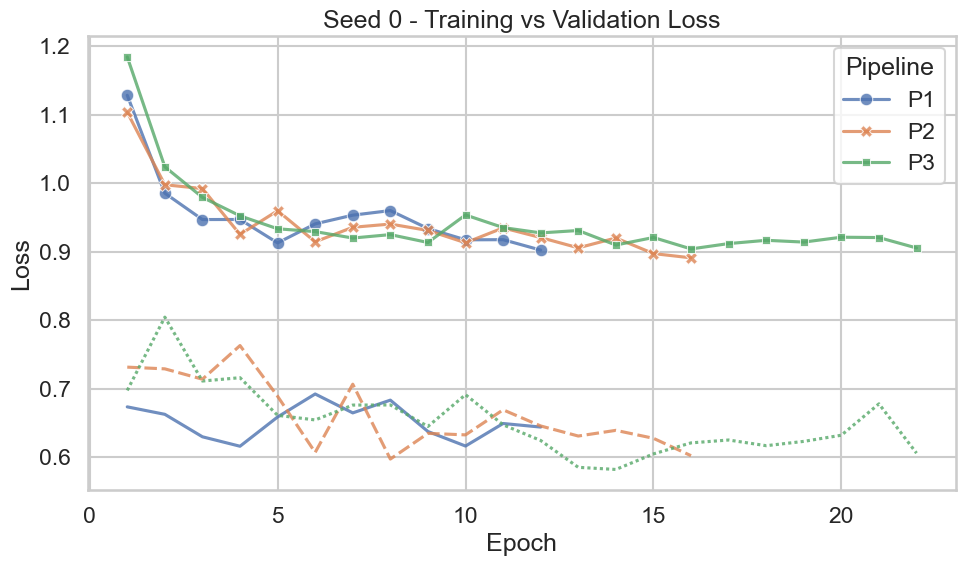

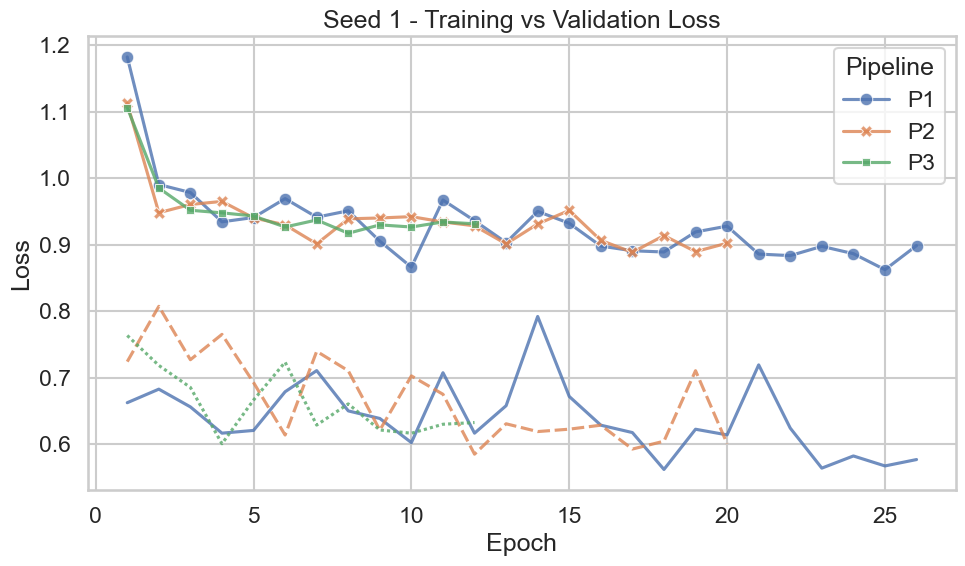

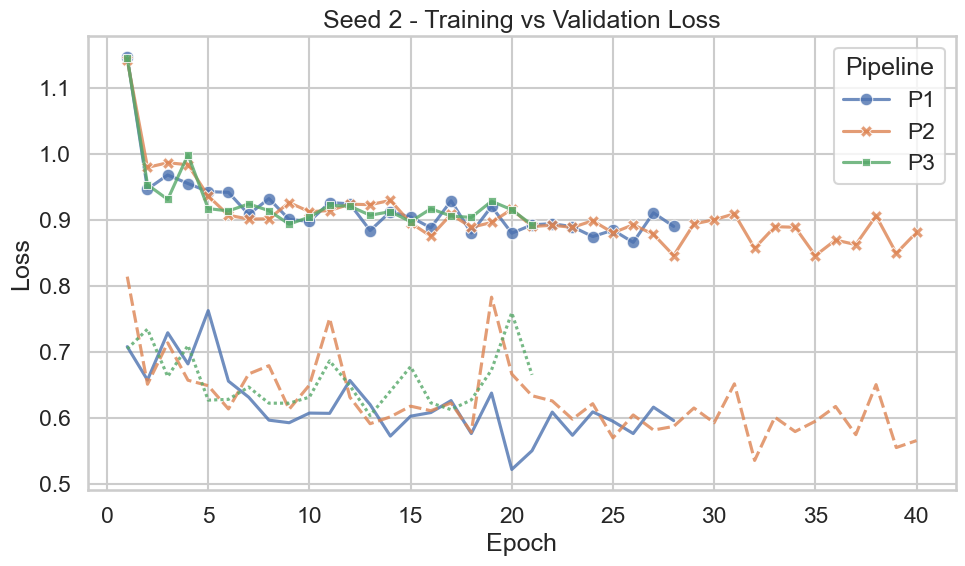

'\nPer-seed training/validation loss plots\n“Training (solid lines) and validation (dotted markers) loss curves for pipelines P1, P2, and P3 across three random seeds. Early stopping was applied, leading to different stopping epochs per run. The curves illustrate convergence behavior and variability across seeds.”\n\nAggregated summary plot (mean ± std)\n“Validation loss across pipelines (P1, P2, P3), averaged over three random seeds. Solid lines show mean validation loss, shaded regions show the standard deviation across seeds, and early stopping resulted in different effective training lengths.\n'

In [33]:
from utils.visualize import plot_losses_per_seed, plot_loss_summary

# Plot per-seed results
plot_losses_per_seed("results/training_logs.csv")


"""
Per-seed plots
“Training and validation loss for each pipeline (P1, P2, P3) under a fixed random seed. Solid lines show training loss, dashed lines show validation loss. Vertical dashed lines indicate early stopping points.”

Training loss summary
“Training loss across pipelines (P1, P2, P3), averaged over three random seeds. Solid lines show mean training loss, shaded regions show the standard deviation across seeds, and vertical dashed lines mark early stopping epochs from individual runs.”

Validation loss summary
“Validation loss across pipelines (P1, P2, P3), averaged over three random seeds. Solid lines show mean validation loss, shaded regions show the standard deviation across seeds, and early stopping resulted in different effective training lengths.”
"""


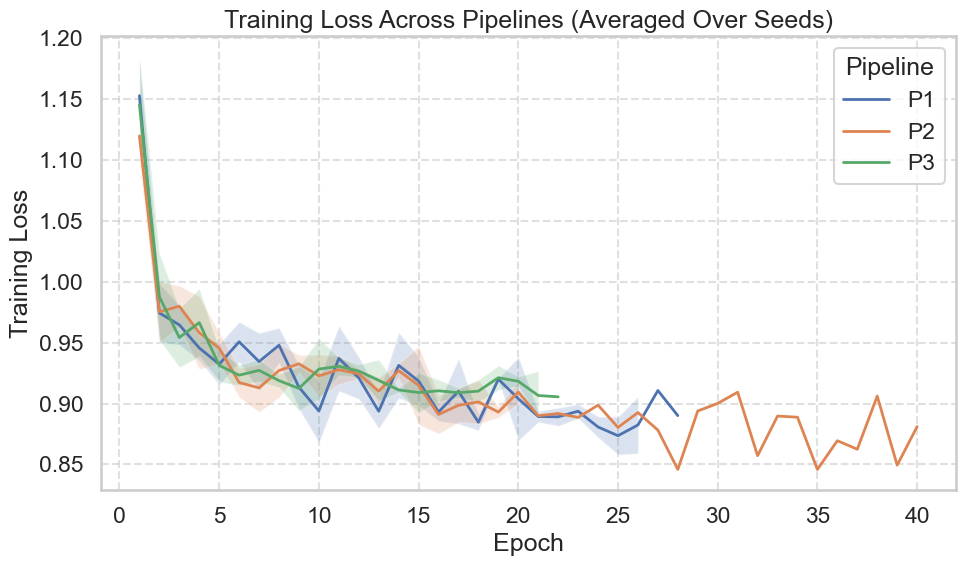

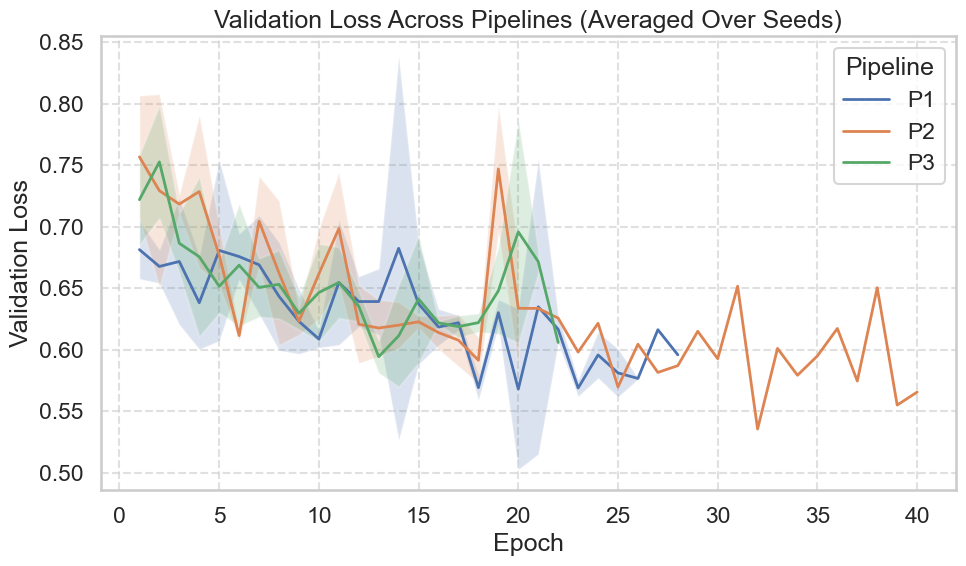

In [31]:
# Plot summary (averaged over seeds)
plot_loss_summary("results/training_logs.csv")


In [26]:
#Computing BRATS dice (for WT, TC, ET) on trained checkpoints
# Re-evaluate trained models with BraTS metrics

# ===========================================================
# Aggregate Dice results across seeds for both metrics
#   - Per-class Dice (Background, Edema, Non-enh, Enh)
#   - BraTS Dice (WT, TC, ET)
# ===========================================================


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = UNet3D(in_ch=4, out_ch=4).to(device)

seeds = [0, 1, 2]   # the seeds you trained with
pipelines = {
    "P1": val_loader_P1,
    "P2": val_loader_P2,
    "P3": val_loader_P3,
}

# storage
# --- Collect results across seeds ---
all_results_perclass = {name: [] for name in pipelines}  # Background, Edema, etc.
all_results_brats    = {name: [] for name in pipelines}  # WT, TC, ET

for seed in seeds:
    print(f"\n=== Evaluating seed {seed} ===")
    for name, val_loader in pipelines.items():
        ckpt = f"models/unet_{name}_s{seed}.pth"
        results = eval_experiment(model, val_loader, ckpt, f"{name}_s{seed}", device)

        # just grab the mean part
        all_results_perclass[name].append(results["dice_class"][0])       # mean per-class dice
        all_results_brats[name].append(results["dice_brats"][0])    # mean WT/TC/ET dice

# --- Aggregate results across seeds ---
print("\n=== Final aggregated results (across seeds) ===")
for name in pipelines.keys():
    # stack into arrays
    perclass = np.stack(all_results_perclass[name])  # (num_seeds, 4)
    brats    = np.stack(all_results_brats[name])     # (num_seeds, 3)

    mean_pc, std_pc = perclass.mean(axis=0), perclass.std(axis=0)
    mean_b, std_b   = brats.mean(axis=0), brats.std(axis=0)

    print(f"\n{name}:")
    print("  Per-class Dice:", mean_pc, "±", std_pc)
    print("  BraTS (WT, TC, ET):", mean_b, "±", std_b)


Using device: cuda

=== Evaluating seed 0 ===

=== Results for P1_s0 ===


C:\Projects\CV_final project\UNET_BTS\utils\evaluate_unet.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi


Per-class Dice (debugging and pipeline selection):
  Background     : 0.941 ± 0.030
  Edema          : 0.393 ± 0.278
  Non-enhancing  : 0.646 ± 0.202
  Enhancing      : 0.668 ± 0.226

BraTS region Dice (Model comparison , BRATS format):
  WT: 0.825 ± 0.076
  TC: 0.706 ± 0.169
  ET: 0.668 ± 0.226

=== Results for P2_s0 ===

Per-class Dice (debugging and pipeline selection):
  Background     : 0.944 ± 0.029
  Edema          : 0.371 ± 0.266
  Non-enhancing  : 0.648 ± 0.196
  Enhancing      : 0.646 ± 0.224

BraTS region Dice (Model comparison , BRATS format):
  WT: 0.834 ± 0.078
  TC: 0.709 ± 0.159
  ET: 0.646 ± 0.224

=== Results for P3_s0 ===

Per-class Dice (debugging and pipeline selection):
  Background     : 0.948 ± 0.025
  Edema          : 0.439 ± 0.281
  Non-enhancing  : 0.633 ± 0.186
  Enhancing      : 0.663 ± 0.233

BraTS region Dice (Model comparison , BRATS format):
  WT: 0.845 ± 0.073
  TC: 0.691 ± 0.162
  ET: 0.663 ± 0.233

=== Evaluating seed 1 ===

=== Results for P1_s1 ==

In [45]:
# all_results

Optimized U-Net Setup (Model development) using P2 as selected pipeline

Training Loop (Optimized) using P2 as selected pipeline

In [41]:
# # --- CONFIG ---
# epochs   = 50        # full ablation
# patience = 10
# lr       = 1e-3
# device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

# seeds = [0, 1, 2]   # multiple runs for robustness
# all_results = []

# # --- Training & Evaluation ---
# for seed in seeds:
#     print(f"\n=== Training on P2 with seed {seed} ===")
#     set_global_seed(seed)

#     # fresh model & optimizer per seed
#     model = UNet3D_optimized(
#     in_ch=4,
#     out_ch=4,
#     dropout=0.0,
#     deep_supervision=False,
#     use_attention=False
#     ).to(device)
    
#     loss_fn = DiceCELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#     ckpt, hist, total_time, avg_epoch, peak_mem = run_experiment(
#         model, optimizer, loss_fn,
#         train_loader_P2, val_loader_P2,
#         f"P2_s{seed}", device, epochs, lr, patience
#     )

#     results = eval_experiment(model, val_loader_P2, ckpt, f"P2_s{seed}", device)
#     results["time"] = (total_time, avg_epoch, peak_mem)
#     all_results.append(results)

# # --- Aggregate ---
# print("\n=== Final aggregated results (P2 across seeds) ===")
# brats_means = [r["dice_brats"][0] for r in all_results]
# brats_stds  = [r["dice_brats"][1] for r in all_results]

# mean_dice = np.mean(brats_means, axis=0)
# std_dice  = np.mean(brats_stds, axis=0)

# for name, m, s in zip(["WT", "TC", "ET"], mean_dice, std_dice):
#     print(f"{name}: {m:.3f} ± {s:.3f}")


Using device: cuda

=== Training on P2 with seed 0 ===
Global seed set to 0

=== Training UNet on P2_s0 ===


Epoch 1/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:45<00:00,  1.61it/s]


Epoch 1/50: Train Loss=1.0489, Val Loss=0.6181, Time=253.55s
New best model saved at models/unet_P2_s0.pth (Val Loss=0.6181)


Epoch 2/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.09it/s]


Epoch 2/50: Train Loss=0.9943, Val Loss=0.6289, Time=243.15s


Epoch 3/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.10it/s]


Epoch 3/50: Train Loss=0.9506, Val Loss=0.6081, Time=244.24s
New best model saved at models/unet_P2_s0.pth (Val Loss=0.6081)


Epoch 4/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.07it/s]


Epoch 4/50: Train Loss=0.9600, Val Loss=0.6444, Time=245.05s


Epoch 5/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.10it/s]


Epoch 5/50: Train Loss=0.9117, Val Loss=0.7529, Time=245.18s


Epoch 6/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.08it/s]


Epoch 6/50: Train Loss=0.8768, Val Loss=0.5189, Time=251.76s
New best model saved at models/unet_P2_s0.pth (Val Loss=0.5189)


Epoch 7/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.78it/s]


Epoch 7/50: Train Loss=0.9137, Val Loss=0.5070, Time=263.30s
New best model saved at models/unet_P2_s0.pth (Val Loss=0.5070)


Epoch 8/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.07it/s]


Epoch 8/50: Train Loss=0.8915, Val Loss=0.5330, Time=257.64s


Epoch 9/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.19it/s]


Epoch 9/50: Train Loss=0.8754, Val Loss=0.5337, Time=237.99s


Epoch 10/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.20it/s]


Epoch 10/50: Train Loss=0.8531, Val Loss=0.5602, Time=236.39s


Epoch 11/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.19it/s]


Epoch 11/50: Train Loss=0.8219, Val Loss=0.5665, Time=234.99s


Epoch 12/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.21it/s]


Epoch 12/50: Train Loss=0.8681, Val Loss=0.5145, Time=234.65s


Epoch 13/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.08it/s]


Epoch 13/50: Train Loss=0.8855, Val Loss=0.5160, Time=235.19s


Epoch 14/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.99it/s]


Epoch 14/50: Train Loss=0.8656, Val Loss=0.5833, Time=241.92s


Epoch 15/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.03it/s]


Epoch 15/50: Train Loss=0.8737, Val Loss=0.4849, Time=237.41s
New best model saved at models/unet_P2_s0.pth (Val Loss=0.4849)


Epoch 16/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.13it/s]


Epoch 16/50: Train Loss=0.8491, Val Loss=0.4773, Time=236.28s
New best model saved at models/unet_P2_s0.pth (Val Loss=0.4773)


Epoch 17/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.08it/s]


Epoch 17/50: Train Loss=0.8514, Val Loss=0.5616, Time=235.50s


Epoch 18/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.02it/s]


Epoch 18/50: Train Loss=0.8637, Val Loss=0.5912, Time=236.00s


Epoch 19/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.03it/s]


Epoch 19/50: Train Loss=0.8702, Val Loss=0.5375, Time=235.71s


Epoch 20/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.10it/s]


Epoch 20/50: Train Loss=0.8787, Val Loss=0.5802, Time=235.05s


Epoch 21/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.02it/s]


Epoch 21/50: Train Loss=0.8595, Val Loss=0.5168, Time=236.29s


Epoch 22/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.10it/s]


Epoch 22/50: Train Loss=0.8904, Val Loss=0.6009, Time=235.24s


Epoch 23/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.02it/s]


Epoch 23/50: Train Loss=0.8548, Val Loss=0.5566, Time=235.96s


Epoch 24/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.02it/s]


Epoch 24/50: Train Loss=0.8431, Val Loss=0.5183, Time=236.08s


Epoch 25/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.26it/s]


Epoch 25/50: Train Loss=0.8722, Val Loss=0.5207, Time=240.80s


Epoch 26/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.10it/s]


Epoch 26/50: Train Loss=0.8695, Val Loss=0.6064, Time=232.80s
Early stopping triggered.

=== Training Summary ===
Total time: 104.31 min
Avg epoch time: 240.70 s
Peak GPU memory: 2612.57 MB

=== Results for P2_s0 ===

Per-class Dice (debugging and pipeline selection):
  Background     : 0.956 ± 0.023
  Edema          : 0.520 ± 0.303
  Non-enhancing  : 0.691 ± 0.199
  Enhancing      : 0.625 ± 0.284

BraTS region Dice (Model comparison , BRATS format):
  WT: 0.860 ± 0.087
  TC: 0.756 ± 0.173
  ET: 0.625 ± 0.284

=== Training on P2 with seed 1 ===
Global seed set to 1

=== Training UNet on P2_s1 ===


Epoch 1/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.15it/s]


Epoch 1/50: Train Loss=1.0547, Val Loss=0.6248, Time=231.61s
New best model saved at models/unet_P2_s1.pth (Val Loss=0.6248)


Epoch 2/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.13it/s]


Epoch 2/50: Train Loss=0.9582, Val Loss=0.7386, Time=231.44s


Epoch 3/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.17it/s]


Epoch 3/50: Train Loss=0.9521, Val Loss=0.6110, Time=231.37s
New best model saved at models/unet_P2_s1.pth (Val Loss=0.6110)


Epoch 4/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.12it/s]


Epoch 4/50: Train Loss=0.9436, Val Loss=0.7494, Time=231.81s


Epoch 5/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.19it/s]


Epoch 5/50: Train Loss=0.9098, Val Loss=0.6001, Time=232.28s
New best model saved at models/unet_P2_s1.pth (Val Loss=0.6001)


Epoch 6/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.26it/s]


Epoch 6/50: Train Loss=0.8889, Val Loss=0.5876, Time=231.98s
New best model saved at models/unet_P2_s1.pth (Val Loss=0.5876)


Epoch 7/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.18it/s]


Epoch 7/50: Train Loss=0.9172, Val Loss=0.6142, Time=232.64s


Epoch 8/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.19it/s]


Epoch 8/50: Train Loss=0.9142, Val Loss=0.5425, Time=232.12s
New best model saved at models/unet_P2_s1.pth (Val Loss=0.5425)


Epoch 9/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.77it/s]


Epoch 9/50: Train Loss=0.8754, Val Loss=0.6965, Time=236.71s


Epoch 10/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.25it/s]


Epoch 10/50: Train Loss=0.8908, Val Loss=0.6227, Time=231.17s


Epoch 11/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.83it/s]


Epoch 11/50: Train Loss=0.8634, Val Loss=0.4761, Time=235.31s
New best model saved at models/unet_P2_s1.pth (Val Loss=0.4761)


Epoch 12/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.18it/s]


Epoch 12/50: Train Loss=0.8854, Val Loss=0.5390, Time=245.77s


Epoch 13/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.21it/s]


Epoch 13/50: Train Loss=0.8946, Val Loss=0.5911, Time=232.33s


Epoch 14/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.16it/s]


Epoch 14/50: Train Loss=0.8755, Val Loss=0.5358, Time=231.96s


Epoch 15/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.01it/s]


Epoch 15/50: Train Loss=0.8623, Val Loss=0.6202, Time=233.05s


Epoch 16/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.14it/s]


Epoch 16/50: Train Loss=0.8602, Val Loss=0.6452, Time=234.46s


Epoch 17/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.66it/s]


Epoch 17/50: Train Loss=0.8677, Val Loss=0.5783, Time=238.59s


Epoch 18/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.99it/s]


Epoch 18/50: Train Loss=0.8449, Val Loss=0.5279, Time=234.75s


Epoch 19/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.18it/s]


Epoch 19/50: Train Loss=0.8407, Val Loss=0.5413, Time=232.43s


Epoch 20/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 20/50: Train Loss=0.8460, Val Loss=0.5072, Time=231.83s


Epoch 21/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.22it/s]


Epoch 21/50: Train Loss=0.8833, Val Loss=0.6189, Time=231.86s
Early stopping triggered.

=== Training Summary ===
Total time: 81.76 min
Avg epoch time: 233.61 s
Peak GPU memory: 2612.57 MB

=== Results for P2_s1 ===

Per-class Dice (debugging and pipeline selection):
  Background     : 0.960 ± 0.017
  Edema          : 0.511 ± 0.285
  Non-enhancing  : 0.710 ± 0.194
  Enhancing      : 0.693 ± 0.251

BraTS region Dice (Model comparison , BRATS format):
  WT: 0.868 ± 0.093
  TC: 0.770 ± 0.160
  ET: 0.693 ± 0.251

=== Training on P2 with seed 2 ===
Global seed set to 2

=== Training UNet on P2_s2 ===


Epoch 1/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.22it/s]


Epoch 1/50: Train Loss=1.0843, Val Loss=0.6763, Time=231.40s
New best model saved at models/unet_P2_s2.pth (Val Loss=0.6763)


Epoch 2/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.18it/s]


Epoch 2/50: Train Loss=0.9559, Val Loss=0.6251, Time=232.03s
New best model saved at models/unet_P2_s2.pth (Val Loss=0.6251)


Epoch 3/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.22it/s]


Epoch 3/50: Train Loss=0.9499, Val Loss=0.6532, Time=231.22s


Epoch 4/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.79it/s]


Epoch 4/50: Train Loss=0.9244, Val Loss=0.6261, Time=235.62s


Epoch 5/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.24it/s]


Epoch 5/50: Train Loss=0.9151, Val Loss=0.6397, Time=238.17s


Epoch 6/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 6/50: Train Loss=0.9572, Val Loss=0.6782, Time=230.85s


Epoch 7/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.25it/s]


Epoch 7/50: Train Loss=0.8963, Val Loss=0.7151, Time=230.98s


Epoch 8/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.22it/s]


Epoch 8/50: Train Loss=0.9087, Val Loss=0.5926, Time=231.69s
New best model saved at models/unet_P2_s2.pth (Val Loss=0.5926)


Epoch 9/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.26it/s]


Epoch 9/50: Train Loss=0.8454, Val Loss=0.5007, Time=230.83s
New best model saved at models/unet_P2_s2.pth (Val Loss=0.5007)


Epoch 10/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.22it/s]


Epoch 10/50: Train Loss=0.8753, Val Loss=0.6345, Time=231.25s


Epoch 11/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 11/50: Train Loss=0.8882, Val Loss=0.6292, Time=231.60s


Epoch 12/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 12/50: Train Loss=0.9037, Val Loss=0.6170, Time=232.07s


Epoch 13/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.20it/s]


Epoch 13/50: Train Loss=0.8799, Val Loss=0.6081, Time=231.62s


Epoch 14/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 14/50: Train Loss=0.8671, Val Loss=0.5547, Time=231.24s


Epoch 15/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.21it/s]


Epoch 15/50: Train Loss=0.8618, Val Loss=0.5693, Time=230.89s


Epoch 16/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.20it/s]


Epoch 16/50: Train Loss=0.8851, Val Loss=0.5728, Time=231.36s


Epoch 17/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.21it/s]


Epoch 17/50: Train Loss=0.8619, Val Loss=0.5857, Time=232.15s


Epoch 18/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.20it/s]


Epoch 18/50: Train Loss=0.8783, Val Loss=0.6148, Time=232.08s


Epoch 19/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.71it/s]


Epoch 19/50: Train Loss=0.8433, Val Loss=0.5867, Time=236.77s
Early stopping triggered.

=== Training Summary ===
Total time: 73.57 min
Avg epoch time: 232.31 s
Peak GPU memory: 2612.57 MB

=== Results for P2_s2 ===

Per-class Dice (debugging and pipeline selection):
  Background     : 0.952 ± 0.025
  Edema          : 0.440 ± 0.290
  Non-enhancing  : 0.675 ± 0.206
  Enhancing      : 0.659 ± 0.250

BraTS region Dice (Model comparison , BRATS format):
  WT: 0.847 ± 0.073
  TC: 0.743 ± 0.165
  ET: 0.659 ± 0.250

=== Final aggregated results (P2 across seeds) ===
WT: 0.858 ± 0.084
TC: 0.756 ± 0.166
ET: 0.659 ± 0.262


Training and eval of (Optimized) unet using P2 as selected pipeline

In [24]:
# --- CONFIG ---
epochs   = 50        # full ablation
patience = 10
lr       = 1e-3
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

seeds = [0, 1, 2]   # multiple runs for robustness
all_results = []

# --- Training & Evaluation ---
for seed in seeds:
    print(f"\n=== Training on P2 with seed {seed} ===")
    set_global_seed(seed)

    # fresh model & optimizer per seed
    model = UNet3D_optimized(
    in_ch=4,
    out_ch=4,
    dropout=0.1
    ).to(device)
    
    loss_fn = DiceCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",          # minimize val loss
        factor=0.5,          # reduce LR by half
        patience=3,          # wait 3 epochs without improvement
        min_lr=1e-6,         # don’t go too small
        verbose=True
    )
    ckpt, hist, total_time, avg_epoch, peak_mem = run_experiment(
        model, optimizer, loss_fn,
        train_loader_P2, val_loader_P2,
        f"P2_opt_s{seed}", device, epochs, lr, patience, scheduler  
    )

    results = eval_experiment(model, val_loader_P2, ckpt, f"P2_s{seed}", device)
    results["time"] = (total_time, avg_epoch, peak_mem)
    all_results.append(results)

# --- Aggregate ---
print("\n=== Final aggregated results (P2 across seeds) ===")
brats_means = [r["dice_brats"][0] for r in all_results]
brats_stds  = [r["dice_brats"][1] for r in all_results]

mean_dice = np.mean(brats_means, axis=0)
std_dice  = np.mean(brats_stds, axis=0)

for name, m, s in zip(["WT", "TC", "ET"], mean_dice, std_dice):
    print(f"{name}: {m:.3f} ± {s:.3f}")


Using device: cuda

=== Training on P2 with seed 0 ===
Global seed set to 0


C:\ProgramData\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training UNet on P2_opt_s0 ===


Epoch 1/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.96it/s]


Epoch 1/50: Train Loss=1.0293, Val Loss=0.6475, Time=220.43s
--> LR adjusted to 1.00e-03
New best model saved at models/unet_P2_opt_s0.pth (Val Loss=0.6475)


Epoch 2/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.78it/s]


Epoch 2/50: Train Loss=0.9681, Val Loss=0.6286, Time=228.03s
--> LR adjusted to 1.00e-03
New best model saved at models/unet_P2_opt_s0.pth (Val Loss=0.6286)


Epoch 3/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.30it/s]


Epoch 3/50: Train Loss=0.9489, Val Loss=0.6349, Time=222.30s
--> LR adjusted to 1.00e-03


Epoch 4/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.25it/s]


Epoch 4/50: Train Loss=0.9405, Val Loss=0.6001, Time=222.88s
--> LR adjusted to 1.00e-03
New best model saved at models/unet_P2_opt_s0.pth (Val Loss=0.6001)


Epoch 5/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 5/50: Train Loss=0.9289, Val Loss=0.6487, Time=223.25s
--> LR adjusted to 1.00e-03


Epoch 6/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.88it/s]


Epoch 6/50: Train Loss=0.9416, Val Loss=0.5807, Time=225.81s
--> LR adjusted to 1.00e-03
New best model saved at models/unet_P2_opt_s0.pth (Val Loss=0.5807)


Epoch 7/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.26it/s]


Epoch 7/50: Train Loss=0.9322, Val Loss=0.6021, Time=230.77s
--> LR adjusted to 1.00e-03


Epoch 8/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.25it/s]


Epoch 8/50: Train Loss=0.9132, Val Loss=0.5693, Time=222.87s
--> LR adjusted to 1.00e-03
New best model saved at models/unet_P2_opt_s0.pth (Val Loss=0.5693)


Epoch 9/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.10it/s]


Epoch 9/50: Train Loss=0.9385, Val Loss=0.6074, Time=224.89s
--> LR adjusted to 1.00e-03


Epoch 10/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.21it/s]


Epoch 10/50: Train Loss=0.9234, Val Loss=0.6191, Time=224.10s
--> LR adjusted to 1.00e-03


Epoch 11/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.08it/s]


Epoch 11/50: Train Loss=0.9287, Val Loss=0.6721, Time=225.54s
--> LR adjusted to 1.00e-03


Epoch 12/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.26it/s]


Epoch 12/50: Train Loss=0.9483, Val Loss=0.5724, Time=222.40s
--> LR adjusted to 5.00e-04


Epoch 13/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.99it/s]


Epoch 13/50: Train Loss=0.8922, Val Loss=0.5799, Time=225.72s
--> LR adjusted to 5.00e-04


Epoch 14/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.17it/s]


Epoch 14/50: Train Loss=0.9284, Val Loss=0.6308, Time=223.89s
--> LR adjusted to 5.00e-04


Epoch 15/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.91it/s]


Epoch 15/50: Train Loss=0.9243, Val Loss=0.6280, Time=224.86s
--> LR adjusted to 5.00e-04


Epoch 16/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.07it/s]


Epoch 16/50: Train Loss=0.9134, Val Loss=0.6013, Time=224.64s
--> LR adjusted to 2.50e-04


Epoch 17/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.32it/s]


Epoch 17/50: Train Loss=0.9043, Val Loss=0.5882, Time=221.84s
--> LR adjusted to 2.50e-04


Epoch 18/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.98it/s]


Epoch 18/50: Train Loss=0.9028, Val Loss=0.5628, Time=226.50s
--> LR adjusted to 2.50e-04
New best model saved at models/unet_P2_opt_s0.pth (Val Loss=0.5628)


Epoch 19/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.24it/s]


Epoch 19/50: Train Loss=0.8877, Val Loss=0.5682, Time=223.03s
--> LR adjusted to 2.50e-04


Epoch 20/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.02it/s]


Epoch 20/50: Train Loss=0.8608, Val Loss=0.5734, Time=224.76s
--> LR adjusted to 2.50e-04


Epoch 21/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.15it/s]


Epoch 21/50: Train Loss=0.8802, Val Loss=0.5674, Time=224.16s
--> LR adjusted to 2.50e-04


Epoch 22/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.21it/s]


Epoch 22/50: Train Loss=0.8937, Val Loss=0.5821, Time=222.40s
--> LR adjusted to 1.25e-04


Epoch 23/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.28it/s]


Epoch 23/50: Train Loss=0.8780, Val Loss=0.5838, Time=222.41s
--> LR adjusted to 1.25e-04


Epoch 24/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.05it/s]


Epoch 24/50: Train Loss=0.8797, Val Loss=0.5888, Time=224.42s
--> LR adjusted to 1.25e-04


Epoch 25/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.91it/s]


Epoch 25/50: Train Loss=0.8787, Val Loss=0.5644, Time=225.78s
--> LR adjusted to 1.25e-04


Epoch 26/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.27it/s]


Epoch 26/50: Train Loss=0.8830, Val Loss=0.6087, Time=221.67s
--> LR adjusted to 6.25e-05


Epoch 27/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.21it/s]


Epoch 27/50: Train Loss=0.8480, Val Loss=0.5586, Time=223.91s
--> LR adjusted to 6.25e-05
New best model saved at models/unet_P2_opt_s0.pth (Val Loss=0.5586)


Epoch 28/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.26it/s]


Epoch 28/50: Train Loss=0.8644, Val Loss=0.5524, Time=222.18s
--> LR adjusted to 6.25e-05
New best model saved at models/unet_P2_opt_s0.pth (Val Loss=0.5524)


Epoch 29/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.94it/s]


Epoch 29/50: Train Loss=0.8601, Val Loss=0.5582, Time=225.09s
--> LR adjusted to 6.25e-05


Epoch 30/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:44<00:00,  1.67it/s]


Epoch 30/50: Train Loss=0.8957, Val Loss=0.5670, Time=244.05s
--> LR adjusted to 6.25e-05


Epoch 31/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.04it/s]


Epoch 31/50: Train Loss=0.8395, Val Loss=0.5502, Time=222.23s
--> LR adjusted to 6.25e-05
New best model saved at models/unet_P2_opt_s0.pth (Val Loss=0.5502)


Epoch 32/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 32/50: Train Loss=0.8623, Val Loss=0.5517, Time=221.55s
--> LR adjusted to 6.25e-05


Epoch 33/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.04it/s]


Epoch 33/50: Train Loss=0.8782, Val Loss=0.5498, Time=223.18s
--> LR adjusted to 6.25e-05
New best model saved at models/unet_P2_opt_s0.pth (Val Loss=0.5498)


Epoch 34/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.29it/s]


Epoch 34/50: Train Loss=0.8513, Val Loss=0.5547, Time=221.93s
--> LR adjusted to 6.25e-05


Epoch 35/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.05it/s]


Epoch 35/50: Train Loss=0.8742, Val Loss=0.5617, Time=224.67s
--> LR adjusted to 6.25e-05


Epoch 36/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.88it/s]


Epoch 36/50: Train Loss=0.8523, Val Loss=0.5577, Time=226.00s
--> LR adjusted to 6.25e-05


Epoch 37/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.96it/s]


Epoch 37/50: Train Loss=0.8418, Val Loss=0.5263, Time=224.35s
--> LR adjusted to 6.25e-05
New best model saved at models/unet_P2_opt_s0.pth (Val Loss=0.5263)


Epoch 38/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.22it/s]


Epoch 38/50: Train Loss=0.8343, Val Loss=0.5380, Time=228.72s
--> LR adjusted to 6.25e-05


Epoch 39/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.28it/s]


Epoch 39/50: Train Loss=0.8302, Val Loss=0.5350, Time=221.18s
--> LR adjusted to 6.25e-05


Epoch 40/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.98it/s]


Epoch 40/50: Train Loss=0.8823, Val Loss=0.5749, Time=224.91s
--> LR adjusted to 6.25e-05


Epoch 41/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.98it/s]


Epoch 41/50: Train Loss=0.8485, Val Loss=0.5547, Time=224.10s
--> LR adjusted to 3.13e-05


Epoch 42/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.19it/s]


Epoch 42/50: Train Loss=0.8411, Val Loss=0.5459, Time=222.49s
--> LR adjusted to 3.13e-05


Epoch 43/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.85it/s]


Epoch 43/50: Train Loss=0.8341, Val Loss=0.5273, Time=225.65s
--> LR adjusted to 3.13e-05


Epoch 44/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.24it/s]


Epoch 44/50: Train Loss=0.8787, Val Loss=0.5589, Time=221.32s
--> LR adjusted to 3.13e-05


Epoch 45/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.02it/s]


Epoch 45/50: Train Loss=0.8466, Val Loss=0.5579, Time=224.75s
--> LR adjusted to 1.56e-05


Epoch 46/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.31it/s]


Epoch 46/50: Train Loss=0.8299, Val Loss=0.5381, Time=222.10s
--> LR adjusted to 1.56e-05


Epoch 47/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.08it/s]
C:\Projects\CV_final project\UNET_BTS\utils\evaluate_unet.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitH

Epoch 47/50: Train Loss=0.8385, Val Loss=0.5372, Time=224.04s
--> LR adjusted to 1.56e-05
Early stopping triggered.

=== Training Summary ===
Total time: 175.80 min
Avg epoch time: 224.43 s
Peak GPU memory: 2021.08 MB

=== Results for P2_s0 ===

Per-class Dice (debugging and pipeline selection):
  Background     : 0.948 ± 0.018
  Edema          : 0.521 ± 0.296
  Non-enhancing  : 0.656 ± 0.192
  Enhancing      : 0.652 ± 0.248

BraTS region Dice (Model comparison , BRATS format):
  WT: 0.811 ± 0.103
  TC: 0.712 ± 0.166
  ET: 0.652 ± 0.248

=== Training on P2 with seed 1 ===
Global seed set to 1

=== Training UNet on P2_opt_s1 ===


Epoch 1/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.99it/s]


Epoch 1/50: Train Loss=1.0705, Val Loss=0.7229, Time=224.89s
--> LR adjusted to 1.00e-03
New best model saved at models/unet_P2_opt_s1.pth (Val Loss=0.7229)


Epoch 2/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.20it/s]


Epoch 2/50: Train Loss=0.9521, Val Loss=0.6221, Time=221.86s
--> LR adjusted to 1.00e-03
New best model saved at models/unet_P2_opt_s1.pth (Val Loss=0.6221)


Epoch 3/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.74it/s]


Epoch 3/50: Train Loss=0.9384, Val Loss=0.6563, Time=228.95s
--> LR adjusted to 1.00e-03


Epoch 4/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.15it/s]


Epoch 4/50: Train Loss=0.9729, Val Loss=0.6557, Time=222.80s
--> LR adjusted to 1.00e-03


Epoch 5/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.06it/s]


Epoch 5/50: Train Loss=0.9399, Val Loss=0.6390, Time=225.34s
--> LR adjusted to 1.00e-03


Epoch 6/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.18it/s]


Epoch 6/50: Train Loss=0.9163, Val Loss=0.6054, Time=222.19s
--> LR adjusted to 1.00e-03
New best model saved at models/unet_P2_opt_s1.pth (Val Loss=0.6054)


Epoch 7/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:47<00:00,  1.55it/s]


Epoch 7/50: Train Loss=0.9135, Val Loss=0.6002, Time=257.36s
--> LR adjusted to 1.00e-03
New best model saved at models/unet_P2_opt_s1.pth (Val Loss=0.6002)


Epoch 8/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.05it/s]


Epoch 8/50: Train Loss=0.9042, Val Loss=0.7462, Time=224.16s
--> LR adjusted to 1.00e-03


Epoch 9/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.30it/s]


Epoch 9/50: Train Loss=0.9197, Val Loss=0.6031, Time=222.38s
--> LR adjusted to 1.00e-03


Epoch 10/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:30<00:00,  2.43it/s]


Epoch 10/50: Train Loss=0.9458, Val Loss=0.6119, Time=243.32s
--> LR adjusted to 1.00e-03


Epoch 11/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.84it/s]


Epoch 11/50: Train Loss=0.9310, Val Loss=0.5389, Time=224.32s
--> LR adjusted to 1.00e-03
New best model saved at models/unet_P2_opt_s1.pth (Val Loss=0.5389)


Epoch 12/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.29it/s]


Epoch 12/50: Train Loss=0.9000, Val Loss=0.6631, Time=221.13s
--> LR adjusted to 1.00e-03


Epoch 13/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.06it/s]


Epoch 13/50: Train Loss=0.9118, Val Loss=0.6606, Time=225.07s
--> LR adjusted to 1.00e-03


Epoch 14/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.10it/s]


Epoch 14/50: Train Loss=0.9016, Val Loss=0.6069, Time=222.36s
--> LR adjusted to 1.00e-03


Epoch 15/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.10it/s]


Epoch 15/50: Train Loss=0.9277, Val Loss=0.6373, Time=222.98s
--> LR adjusted to 5.00e-04


Epoch 16/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.20it/s]


Epoch 16/50: Train Loss=0.8956, Val Loss=0.6185, Time=221.99s
--> LR adjusted to 5.00e-04


Epoch 17/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.04it/s]


Epoch 17/50: Train Loss=0.9213, Val Loss=0.6067, Time=224.29s
--> LR adjusted to 5.00e-04


Epoch 18/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.12it/s]


Epoch 18/50: Train Loss=0.9096, Val Loss=0.5824, Time=230.20s
--> LR adjusted to 5.00e-04


Epoch 19/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.07it/s]


Epoch 19/50: Train Loss=0.8904, Val Loss=0.5945, Time=223.26s
--> LR adjusted to 2.50e-04


Epoch 20/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.28it/s]


Epoch 20/50: Train Loss=0.8867, Val Loss=0.6061, Time=221.74s
--> LR adjusted to 2.50e-04


Epoch 21/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.07it/s]


Epoch 21/50: Train Loss=0.8751, Val Loss=0.6169, Time=224.07s
--> LR adjusted to 2.50e-04
Early stopping triggered.

=== Training Summary ===
Total time: 79.25 min
Avg epoch time: 226.42 s
Peak GPU memory: 2021.08 MB

=== Results for P2_s1 ===

Per-class Dice (debugging and pipeline selection):
  Background     : 0.952 ± 0.023
  Edema          : 0.347 ± 0.252
  Non-enhancing  : 0.664 ± 0.208
  Enhancing      : 0.686 ± 0.241

BraTS region Dice (Model comparison , BRATS format):
  WT: 0.845 ± 0.078
  TC: 0.738 ± 0.161
  ET: 0.686 ± 0.241

=== Training on P2 with seed 2 ===
Global seed set to 2

=== Training UNet on P2_opt_s2 ===


Epoch 1/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.20it/s]


Epoch 1/50: Train Loss=1.0918, Val Loss=0.7017, Time=222.52s
--> LR adjusted to 1.00e-03
New best model saved at models/unet_P2_opt_s2.pth (Val Loss=0.7017)


Epoch 2/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 2/50: Train Loss=0.9635, Val Loss=0.6333, Time=222.74s
--> LR adjusted to 1.00e-03
New best model saved at models/unet_P2_opt_s2.pth (Val Loss=0.6333)


Epoch 3/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.31it/s]


Epoch 3/50: Train Loss=0.9652, Val Loss=0.7642, Time=222.02s
--> LR adjusted to 1.00e-03


Epoch 4/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.96it/s]


Epoch 4/50: Train Loss=0.9676, Val Loss=0.6875, Time=235.02s
--> LR adjusted to 1.00e-03


Epoch 5/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.26it/s]


Epoch 5/50: Train Loss=0.9724, Val Loss=0.6698, Time=221.30s
--> LR adjusted to 1.00e-03


Epoch 6/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.98it/s]


Epoch 6/50: Train Loss=0.9016, Val Loss=0.5832, Time=225.20s
--> LR adjusted to 1.00e-03
New best model saved at models/unet_P2_opt_s2.pth (Val Loss=0.5832)


Epoch 7/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.30it/s]


Epoch 7/50: Train Loss=0.9662, Val Loss=0.6350, Time=220.82s
--> LR adjusted to 1.00e-03


Epoch 8/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.12it/s]


Epoch 8/50: Train Loss=0.8947, Val Loss=0.5861, Time=225.13s
--> LR adjusted to 1.00e-03


Epoch 9/50 [Val]: 100%|████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.07it/s]


Epoch 9/50: Train Loss=0.9484, Val Loss=0.6005, Time=223.02s
--> LR adjusted to 1.00e-03


Epoch 10/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.29it/s]


Epoch 10/50: Train Loss=0.8987, Val Loss=0.6075, Time=221.19s
--> LR adjusted to 5.00e-04


Epoch 11/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:26<00:00,  2.82it/s]


Epoch 11/50: Train Loss=0.8980, Val Loss=0.5730, Time=225.37s
--> LR adjusted to 5.00e-04
New best model saved at models/unet_P2_opt_s2.pth (Val Loss=0.5730)


Epoch 12/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.11it/s]


Epoch 12/50: Train Loss=0.9042, Val Loss=0.5905, Time=223.88s
--> LR adjusted to 5.00e-04


Epoch 13/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.27it/s]


Epoch 13/50: Train Loss=0.8938, Val Loss=0.6569, Time=221.76s
--> LR adjusted to 5.00e-04


Epoch 14/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.88it/s]


Epoch 14/50: Train Loss=0.9158, Val Loss=0.7047, Time=225.16s
--> LR adjusted to 5.00e-04


Epoch 15/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.12it/s]


Epoch 15/50: Train Loss=0.8970, Val Loss=0.5885, Time=222.51s
--> LR adjusted to 2.50e-04


Epoch 16/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.27it/s]


Epoch 16/50: Train Loss=0.8918, Val Loss=0.5903, Time=221.69s
--> LR adjusted to 2.50e-04


Epoch 17/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.68it/s]


Epoch 17/50: Train Loss=0.8950, Val Loss=0.6019, Time=227.45s
--> LR adjusted to 2.50e-04


Epoch 18/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.21it/s]


Epoch 18/50: Train Loss=0.8514, Val Loss=0.5708, Time=221.92s
--> LR adjusted to 2.50e-04
New best model saved at models/unet_P2_opt_s2.pth (Val Loss=0.5708)


Epoch 19/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.13it/s]


Epoch 19/50: Train Loss=0.8922, Val Loss=0.6122, Time=223.09s
--> LR adjusted to 2.50e-04


Epoch 20/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.73it/s]


Epoch 20/50: Train Loss=0.8744, Val Loss=0.5978, Time=226.05s
--> LR adjusted to 2.50e-04


Epoch 21/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.14it/s]


Epoch 21/50: Train Loss=0.8615, Val Loss=0.5743, Time=223.03s
--> LR adjusted to 2.50e-04


Epoch 22/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.67it/s]


Epoch 22/50: Train Loss=0.8711, Val Loss=0.5601, Time=229.77s
--> LR adjusted to 2.50e-04
New best model saved at models/unet_P2_opt_s2.pth (Val Loss=0.5601)


Epoch 23/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.22it/s]


Epoch 23/50: Train Loss=0.8565, Val Loss=0.5562, Time=221.45s
--> LR adjusted to 2.50e-04
New best model saved at models/unet_P2_opt_s2.pth (Val Loss=0.5562)


Epoch 24/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.99it/s]


Epoch 24/50: Train Loss=0.8605, Val Loss=0.5353, Time=224.22s
--> LR adjusted to 2.50e-04
New best model saved at models/unet_P2_opt_s2.pth (Val Loss=0.5353)


Epoch 25/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.28it/s]


Epoch 25/50: Train Loss=0.8890, Val Loss=0.5563, Time=220.53s
--> LR adjusted to 2.50e-04


Epoch 26/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.27it/s]


Epoch 26/50: Train Loss=0.8747, Val Loss=0.5411, Time=221.58s
--> LR adjusted to 2.50e-04


Epoch 27/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:29<00:00,  2.47it/s]


Epoch 27/50: Train Loss=0.8585, Val Loss=0.5252, Time=228.38s
--> LR adjusted to 2.50e-04
New best model saved at models/unet_P2_opt_s2.pth (Val Loss=0.5252)


Epoch 28/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.71it/s]


Epoch 28/50: Train Loss=0.8446, Val Loss=0.5899, Time=245.72s
--> LR adjusted to 2.50e-04


Epoch 29/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.23it/s]


Epoch 29/50: Train Loss=0.8430, Val Loss=0.5453, Time=223.39s
--> LR adjusted to 2.50e-04


Epoch 30/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.21it/s]


Epoch 30/50: Train Loss=0.8415, Val Loss=0.5616, Time=222.13s
--> LR adjusted to 2.50e-04


Epoch 31/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.27it/s]


Epoch 31/50: Train Loss=0.8475, Val Loss=0.5477, Time=221.30s
--> LR adjusted to 1.25e-04


Epoch 32/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.00it/s]


Epoch 32/50: Train Loss=0.8552, Val Loss=0.5457, Time=224.47s
--> LR adjusted to 1.25e-04


Epoch 33/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.03it/s]


Epoch 33/50: Train Loss=0.8728, Val Loss=0.5737, Time=223.17s
--> LR adjusted to 1.25e-04


Epoch 34/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.19it/s]


Epoch 34/50: Train Loss=0.8198, Val Loss=0.5212, Time=222.81s
--> LR adjusted to 1.25e-04
New best model saved at models/unet_P2_opt_s2.pth (Val Loss=0.5212)


Epoch 35/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.06it/s]


Epoch 35/50: Train Loss=0.8766, Val Loss=0.5912, Time=223.71s
--> LR adjusted to 1.25e-04


Epoch 36/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.11it/s]


Epoch 36/50: Train Loss=0.8303, Val Loss=0.5509, Time=222.47s
--> LR adjusted to 1.25e-04


Epoch 37/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.98it/s]


Epoch 37/50: Train Loss=0.8422, Val Loss=0.5329, Time=224.59s
--> LR adjusted to 1.25e-04


Epoch 38/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.26it/s]


Epoch 38/50: Train Loss=0.8349, Val Loss=0.5268, Time=221.60s
--> LR adjusted to 6.25e-05


Epoch 39/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.05it/s]


Epoch 39/50: Train Loss=0.8321, Val Loss=0.5145, Time=224.05s
--> LR adjusted to 6.25e-05
New best model saved at models/unet_P2_opt_s2.pth (Val Loss=0.5145)


Epoch 40/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.22it/s]


Epoch 40/50: Train Loss=0.8401, Val Loss=0.5576, Time=222.68s
--> LR adjusted to 6.25e-05


Epoch 41/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.34it/s]


Epoch 41/50: Train Loss=0.8337, Val Loss=0.5172, Time=228.05s
--> LR adjusted to 6.25e-05


Epoch 42/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.19it/s]


Epoch 42/50: Train Loss=0.8411, Val Loss=0.5429, Time=233.74s
--> LR adjusted to 6.25e-05


Epoch 43/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.22it/s]


Epoch 43/50: Train Loss=0.8910, Val Loss=0.5802, Time=235.72s
--> LR adjusted to 3.13e-05


Epoch 44/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.24it/s]


Epoch 44/50: Train Loss=0.8324, Val Loss=0.5479, Time=238.34s
--> LR adjusted to 3.13e-05


Epoch 45/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:28<00:00,  2.64it/s]


Epoch 45/50: Train Loss=0.8373, Val Loss=0.5421, Time=244.26s
--> LR adjusted to 3.13e-05


Epoch 46/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.08it/s]


Epoch 46/50: Train Loss=0.8552, Val Loss=0.5509, Time=247.48s
--> LR adjusted to 3.13e-05


Epoch 47/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:23<00:00,  3.09it/s]


Epoch 47/50: Train Loss=0.8438, Val Loss=0.5373, Time=239.80s
--> LR adjusted to 1.56e-05


Epoch 48/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  3.05it/s]


Epoch 48/50: Train Loss=0.8655, Val Loss=0.5537, Time=242.79s
--> LR adjusted to 1.56e-05


Epoch 49/50 [Val]: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:25<00:00,  2.90it/s]


Epoch 49/50: Train Loss=0.8490, Val Loss=0.5467, Time=243.67s
--> LR adjusted to 1.56e-05
Early stopping triggered.

=== Training Summary ===
Total time: 185.39 min
Avg epoch time: 227.00 s
Peak GPU memory: 2021.08 MB

=== Results for P2_s2 ===

Per-class Dice (debugging and pipeline selection):
  Background     : 0.949 ± 0.019
  Edema          : 0.450 ± 0.301
  Non-enhancing  : 0.667 ± 0.211
  Enhancing      : 0.675 ± 0.247

BraTS region Dice (Model comparison , BRATS format):
  WT: 0.810 ± 0.126
  TC: 0.724 ± 0.183
  ET: 0.675 ± 0.247

=== Final aggregated results (P2 across seeds) ===
WT: 0.822 ± 0.103
TC: 0.725 ± 0.170
ET: 0.671 ± 0.246


Comparison & Visualization

Conclusion